In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2314908, 828)
(2314908, 8)
validation
(310528, 828)
(310528, 8)
test
(312452, 828)
(312452, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/232 [..............................] - ETA: 5:09 - loss: 2.1428 - STD: 0.0443 - MAE: 0.2187

  4/232 [..............................] - ETA: 3s - loss: 2.0839 - STD: 0.0476 - MAE: 0.2165  

  7/232 [..............................] - ETA: 3s - loss: 2.0767 - STD: 0.0430 - MAE: 0.2166

 10/232 [>.............................] - ETA: 3s - loss: 2.0685 - STD: 0.0395 - MAE: 0.2166

 13/232 [>.............................] - ETA: 3s - loss: 2.0637 - STD: 0.0390 - MAE: 0.2165

 17/232 [=>............................] - ETA: 3s - loss: 2.0560 - STD: 0.0377 - MAE: 0.2164

 20/232 [=>............................] - ETA: 3s - loss: 2.0479 - STD: 0.0371 - MAE: 0.2162

 24/232 [==>...........................] - ETA: 3s - loss: 2.0340 - STD: 0.0383 - MAE: 0.2156

 27/232 [==>...........................] - ETA: 3s - loss: 2.0204 - STD: 0.0403 - MAE: 0.2150

 30/232 [==>...........................] - ETA: 3s - loss: 2.0056 - STD: 0.0430 - MAE: 0.2143

 33/232 [===>..........................] - ETA: 3s - loss: 1.9910 - STD: 0.0460 - MAE: 0.2135

 36/232 [===>..........................] - ETA: 3s - loss: 1.9762 - STD: 0.0486 - MAE: 0.2128

 39/232 [====>.........................] - ETA: 3s - loss: 1.9617 - STD: 0.0511 - MAE: 0.2120

 42/232 [====>.........................] - ETA: 3s - loss: 1.9466 - STD: 0.0535 - MAE: 0.2113

 45/232 [====>.........................] - ETA: 3s - loss: 1.9310 - STD: 0.0557 - MAE: 0.2105

 48/232 [=====>........................] - ETA: 3s - loss: 1.9144 - STD: 0.0579 - MAE: 0.2097

 51/232 [=====>........................] - ETA: 3s - loss: 1.8969 - STD: 0.0602 - MAE: 0.2087

 54/232 [=====>........................] - ETA: 3s - loss: 1.8788 - STD: 0.0628 - MAE: 0.2077

 57/232 [======>.......................] - ETA: 3s - loss: 1.8610 - STD: 0.0656 - MAE: 0.2067

 60/232 [======>.......................] - ETA: 2s - loss: 1.8436 - STD: 0.0684 - MAE: 0.2056

 63/232 [=======>......................] - ETA: 2s - loss: 1.8262 - STD: 0.0712 - MAE: 0.2045

 66/232 [=======>......................] - ETA: 2s - loss: 1.8099 - STD: 0.0739 - MAE: 0.2034

 70/232 [========>.....................] - ETA: 2s - loss: 1.7894 - STD: 0.0774 - MAE: 0.2020

 73/232 [========>.....................] - ETA: 2s - loss: 1.7744 - STD: 0.0799 - MAE: 0.2010

 76/232 [========>.....................] - ETA: 2s - loss: 1.7603 - STD: 0.0822 - MAE: 0.2000

 79/232 [=========>....................] - ETA: 2s - loss: 1.7466 - STD: 0.0844 - MAE: 0.1991

 82/232 [=========>....................] - ETA: 2s - loss: 1.7336 - STD: 0.0865 - MAE: 0.1982

 85/232 [=========>....................] - ETA: 2s - loss: 1.7212 - STD: 0.0886 - MAE: 0.1973

 88/232 [==========>...................] - ETA: 2s - loss: 1.7092 - STD: 0.0906 - MAE: 0.1964

 92/232 [==========>...................] - ETA: 2s - loss: 1.6941 - STD: 0.0932 - MAE: 0.1953

 95/232 [===========>..................] - ETA: 2s - loss: 1.6830 - STD: 0.0952 - MAE: 0.1945

 99/232 [===========>..................] - ETA: 2s - loss: 1.6694 - STD: 0.0976 - MAE: 0.1934

103/232 [============>.................] - ETA: 2s - loss: 1.6567 - STD: 0.0999 - MAE: 0.1924

106/232 [============>.................] - ETA: 2s - loss: 1.6476 - STD: 0.1015 - MAE: 0.1917

109/232 [=============>................] - ETA: 2s - loss: 1.6386 - STD: 0.1030 - MAE: 0.1910

112/232 [=============>................] - ETA: 2s - loss: 1.6315 - STD: 0.1045 - MAE: 0.1904

116/232 [==============>...............] - ETA: 2s - loss: 1.6205 - STD: 0.1064 - MAE: 0.1895

119/232 [==============>...............] - ETA: 2s - loss: 1.6124 - STD: 0.1077 - MAE: 0.1889

122/232 [==============>...............] - ETA: 2s - loss: 1.6049 - STD: 0.1090 - MAE: 0.1883

125/232 [===============>..............] - ETA: 2s - loss: 1.5976 - STD: 0.1103 - MAE: 0.1877

128/232 [===============>..............] - ETA: 2s - loss: 1.5905 - STD: 0.1115 - MAE: 0.1872

131/232 [===============>..............] - ETA: 2s - loss: 1.5836 - STD: 0.1126 - MAE: 0.1867

134/232 [================>.............] - ETA: 2s - loss: 1.5770 - STD: 0.1138 - MAE: 0.1861

137/232 [================>.............] - ETA: 2s - loss: 1.5707 - STD: 0.1148 - MAE: 0.1856

140/232 [=================>............] - ETA: 2s - loss: 1.5645 - STD: 0.1159 - MAE: 0.1851

144/232 [=================>............] - ETA: 1s - loss: 1.5565 - STD: 0.1172 - MAE: 0.1845

147/232 [==================>...........] - ETA: 1s - loss: 1.5507 - STD: 0.1182 - MAE: 0.1840

150/232 [==================>...........] - ETA: 1s - loss: 1.5450 - STD: 0.1192 - MAE: 0.1836

153/232 [==================>...........] - ETA: 1s - loss: 1.5396 - STD: 0.1201 - MAE: 0.1831

156/232 [===================>..........] - ETA: 1s - loss: 1.5345 - STD: 0.1210 - MAE: 0.1827

159/232 [===================>..........] - ETA: 1s - loss: 1.5294 - STD: 0.1219 - MAE: 0.1823

162/232 [===================>..........] - ETA: 1s - loss: 1.5244 - STD: 0.1228 - MAE: 0.1819

166/232 [====================>.........] - ETA: 1s - loss: 1.5179 - STD: 0.1239 - MAE: 0.1814

169/232 [====================>.........] - ETA: 1s - loss: 1.5132 - STD: 0.1247 - MAE: 0.1810

172/232 [=====================>........] - ETA: 1s - loss: 1.5085 - STD: 0.1255 - MAE: 0.1806

175/232 [=====================>........] - ETA: 1s - loss: 1.5039 - STD: 0.1262 - MAE: 0.1802

178/232 [======================>.......] - ETA: 1s - loss: 1.4996 - STD: 0.1270 - MAE: 0.1798

182/232 [======================>.......] - ETA: 1s - loss: 1.4940 - STD: 0.1279 - MAE: 0.1794

185/232 [======================>.......] - ETA: 0s - loss: 1.4898 - STD: 0.1286 - MAE: 0.1790

189/232 [=======================>......] - ETA: 0s - loss: 1.4844 - STD: 0.1295 - MAE: 0.1786

192/232 [=======================>......] - ETA: 0s - loss: 1.4804 - STD: 0.1302 - MAE: 0.1782

195/232 [========================>.....] - ETA: 0s - loss: 1.4765 - STD: 0.1309 - MAE: 0.1779

198/232 [========================>.....] - ETA: 0s - loss: 1.4728 - STD: 0.1315 - MAE: 0.1776

201/232 [========================>.....] - ETA: 0s - loss: 1.4691 - STD: 0.1322 - MAE: 0.1773

204/232 [=========================>....] - ETA: 0s - loss: 1.4655 - STD: 0.1328 - MAE: 0.1770

207/232 [=========================>....] - ETA: 0s - loss: 1.4620 - STD: 0.1334 - MAE: 0.1767

211/232 [==========================>...] - ETA: 0s - loss: 1.4574 - STD: 0.1341 - MAE: 0.1763

214/232 [==========================>...] - ETA: 0s - loss: 1.4540 - STD: 0.1347 - MAE: 0.1760

217/232 [===========================>..] - ETA: 0s - loss: 1.4507 - STD: 0.1353 - MAE: 0.1757

220/232 [===========================>..] - ETA: 0s - loss: 1.4474 - STD: 0.1358 - MAE: 0.1754

223/232 [===========================>..] - ETA: 0s - loss: 1.4441 - STD: 0.1363 - MAE: 0.1751

226/232 [============================>.] - ETA: 0s - loss: 1.4410 - STD: 0.1369 - MAE: 0.1749

229/232 [============================>.] - ETA: 0s - loss: 1.4380 - STD: 0.1374 - MAE: 0.1746

232/232 [==============================] - 7s 24ms/step - loss: 1.4350 - STD: 0.1379 - MAE: 0.1743 - val_loss: 1.2734 - val_STD: 0.1701 - val_MAE: 0.1591


Epoch 2/10000


  1/232 [..............................] - ETA: 12s - loss: 1.1913 - STD: 0.1756 - MAE: 0.1539

  4/232 [..............................] - ETA: 4s - loss: 1.1928 - STD: 0.1765 - MAE: 0.1538 

  8/232 [>.............................] - ETA: 3s - loss: 1.1963 - STD: 0.1768 - MAE: 0.1539

 11/232 [>.............................] - ETA: 3s - loss: 1.1982 - STD: 0.1770 - MAE: 0.1539

 15/232 [>.............................] - ETA: 3s - loss: 1.1962 - STD: 0.1777 - MAE: 0.1535

 18/232 [=>............................] - ETA: 3s - loss: 1.1948 - STD: 0.1782 - MAE: 0.1533

 22/232 [=>............................] - ETA: 3s - loss: 1.1956 - STD: 0.1786 - MAE: 0.1532

 25/232 [==>...........................] - ETA: 3s - loss: 1.1951 - STD: 0.1787 - MAE: 0.1532

 29/232 [==>...........................] - ETA: 3s - loss: 1.1944 - STD: 0.1787 - MAE: 0.1531

 33/232 [===>..........................] - ETA: 3s - loss: 1.1955 - STD: 0.1789 - MAE: 0.1531

 36/232 [===>..........................] - ETA: 3s - loss: 1.1954 - STD: 0.1790 - MAE: 0.1530

 40/232 [====>.........................] - ETA: 3s - loss: 1.1939 - STD: 0.1791 - MAE: 0.1529

 44/232 [====>.........................] - ETA: 3s - loss: 1.1937 - STD: 0.1793 - MAE: 0.1528

 48/232 [=====>........................] - ETA: 3s - loss: 1.1929 - STD: 0.1794 - MAE: 0.1527

 52/232 [=====>........................] - ETA: 2s - loss: 1.1927 - STD: 0.1796 - MAE: 0.1526

 56/232 [======>.......................] - ETA: 2s - loss: 1.1914 - STD: 0.1797 - MAE: 0.1525

 59/232 [======>.......................] - ETA: 2s - loss: 1.1904 - STD: 0.1798 - MAE: 0.1525

 63/232 [=======>......................] - ETA: 2s - loss: 1.1886 - STD: 0.1800 - MAE: 0.1523

 67/232 [=======>......................] - ETA: 2s - loss: 1.1870 - STD: 0.1802 - MAE: 0.1521

 70/232 [========>.....................] - ETA: 2s - loss: 1.1861 - STD: 0.1803 - MAE: 0.1521

 73/232 [========>.....................] - ETA: 2s - loss: 1.1853 - STD: 0.1804 - MAE: 0.1520

 76/232 [========>.....................] - ETA: 2s - loss: 1.1847 - STD: 0.1806 - MAE: 0.1519

 79/232 [=========>....................] - ETA: 2s - loss: 1.1838 - STD: 0.1807 - MAE: 0.1518

 83/232 [=========>....................] - ETA: 2s - loss: 1.1825 - STD: 0.1808 - MAE: 0.1517

 86/232 [==========>...................] - ETA: 2s - loss: 1.1815 - STD: 0.1809 - MAE: 0.1516

 90/232 [==========>...................] - ETA: 2s - loss: 1.1806 - STD: 0.1811 - MAE: 0.1515

 94/232 [===========>..................] - ETA: 2s - loss: 1.1793 - STD: 0.1813 - MAE: 0.1513

 97/232 [===========>..................] - ETA: 2s - loss: 1.1784 - STD: 0.1815 - MAE: 0.1512

100/232 [===========>..................] - ETA: 2s - loss: 1.1776 - STD: 0.1816 - MAE: 0.1512

104/232 [============>.................] - ETA: 2s - loss: 1.1765 - STD: 0.1817 - MAE: 0.1510

108/232 [============>.................] - ETA: 2s - loss: 1.1754 - STD: 0.1819 - MAE: 0.1509

112/232 [=============>................] - ETA: 1s - loss: 1.1746 - STD: 0.1821 - MAE: 0.1508

115/232 [=============>................] - ETA: 1s - loss: 1.1739 - STD: 0.1822 - MAE: 0.1507

118/232 [==============>...............] - ETA: 1s - loss: 1.1730 - STD: 0.1823 - MAE: 0.1506

121/232 [==============>...............] - ETA: 1s - loss: 1.1722 - STD: 0.1824 - MAE: 0.1506

124/232 [===============>..............] - ETA: 1s - loss: 1.1715 - STD: 0.1826 - MAE: 0.1505

127/232 [===============>..............] - ETA: 1s - loss: 1.1708 - STD: 0.1827 - MAE: 0.1504

130/232 [===============>..............] - ETA: 1s - loss: 1.1700 - STD: 0.1827 - MAE: 0.1503

133/232 [================>.............] - ETA: 1s - loss: 1.1691 - STD: 0.1828 - MAE: 0.1502

136/232 [================>.............] - ETA: 1s - loss: 1.1682 - STD: 0.1829 - MAE: 0.1502

139/232 [================>.............] - ETA: 1s - loss: 1.1675 - STD: 0.1831 - MAE: 0.1501

143/232 [=================>............] - ETA: 1s - loss: 1.1666 - STD: 0.1832 - MAE: 0.1500

147/232 [==================>...........] - ETA: 1s - loss: 1.1652 - STD: 0.1834 - MAE: 0.1498

151/232 [==================>...........] - ETA: 1s - loss: 1.1642 - STD: 0.1836 - MAE: 0.1497

154/232 [==================>...........] - ETA: 1s - loss: 1.1636 - STD: 0.1837 - MAE: 0.1496

157/232 [===================>..........] - ETA: 1s - loss: 1.1632 - STD: 0.1838 - MAE: 0.1496

160/232 [===================>..........] - ETA: 1s - loss: 1.1627 - STD: 0.1839 - MAE: 0.1495

163/232 [====================>.........] - ETA: 1s - loss: 1.1625 - STD: 0.1840 - MAE: 0.1495

166/232 [====================>.........] - ETA: 1s - loss: 1.1622 - STD: 0.1841 - MAE: 0.1494

169/232 [====================>.........] - ETA: 1s - loss: 1.1618 - STD: 0.1842 - MAE: 0.1494

172/232 [=====================>........] - ETA: 1s - loss: 1.1613 - STD: 0.1842 - MAE: 0.1493

175/232 [=====================>........] - ETA: 0s - loss: 1.1610 - STD: 0.1843 - MAE: 0.1493

179/232 [======================>.......] - ETA: 0s - loss: 1.1603 - STD: 0.1845 - MAE: 0.1492

183/232 [======================>.......] - ETA: 0s - loss: 1.1594 - STD: 0.1846 - MAE: 0.1491

187/232 [=======================>......] - ETA: 0s - loss: 1.1582 - STD: 0.1847 - MAE: 0.1490

191/232 [=======================>......] - ETA: 0s - loss: 1.1571 - STD: 0.1848 - MAE: 0.1489

195/232 [========================>.....] - ETA: 0s - loss: 1.1562 - STD: 0.1850 - MAE: 0.1488

198/232 [========================>.....] - ETA: 0s - loss: 1.1553 - STD: 0.1851 - MAE: 0.1487

202/232 [=========================>....] - ETA: 0s - loss: 1.1542 - STD: 0.1852 - MAE: 0.1486

206/232 [=========================>....] - ETA: 0s - loss: 1.1534 - STD: 0.1854 - MAE: 0.1485

210/232 [==========================>...] - ETA: 0s - loss: 1.1527 - STD: 0.1855 - MAE: 0.1484

213/232 [==========================>...] - ETA: 0s - loss: 1.1523 - STD: 0.1856 - MAE: 0.1483

217/232 [===========================>..] - ETA: 0s - loss: 1.1513 - STD: 0.1857 - MAE: 0.1482

221/232 [===========================>..] - ETA: 0s - loss: 1.1506 - STD: 0.1858 - MAE: 0.1482

224/232 [===========================>..] - ETA: 0s - loss: 1.1501 - STD: 0.1859 - MAE: 0.1481

227/232 [============================>.] - ETA: 0s - loss: 1.1495 - STD: 0.1860 - MAE: 0.1481

231/232 [============================>.] - ETA: 0s - loss: 1.1487 - STD: 0.1861 - MAE: 0.1480

232/232 [==============================] - 4s 19ms/step - loss: 1.1485 - STD: 0.1861 - MAE: 0.1479 - val_loss: 1.1820 - val_STD: 0.1864 - val_MAE: 0.1490


Epoch 3/10000


  1/232 [..............................] - ETA: 11s - loss: 1.1024 - STD: 0.1927 - MAE: 0.1430

  4/232 [..............................] - ETA: 4s - loss: 1.1076 - STD: 0.1930 - MAE: 0.1432 

  8/232 [>.............................] - ETA: 3s - loss: 1.1059 - STD: 0.1926 - MAE: 0.1433

 12/232 [>.............................] - ETA: 3s - loss: 1.1049 - STD: 0.1925 - MAE: 0.1433

 15/232 [>.............................] - ETA: 3s - loss: 1.1025 - STD: 0.1928 - MAE: 0.1430

 18/232 [=>............................] - ETA: 3s - loss: 1.0988 - STD: 0.1930 - MAE: 0.1428

 21/232 [=>............................] - ETA: 3s - loss: 1.0991 - STD: 0.1932 - MAE: 0.1427

 24/232 [==>...........................] - ETA: 3s - loss: 1.0983 - STD: 0.1934 - MAE: 0.1426

 27/232 [==>...........................] - ETA: 3s - loss: 1.1004 - STD: 0.1934 - MAE: 0.1427

 30/232 [==>...........................] - ETA: 3s - loss: 1.1000 - STD: 0.1934 - MAE: 0.1427

 33/232 [===>..........................] - ETA: 3s - loss: 1.0984 - STD: 0.1935 - MAE: 0.1426

 36/232 [===>..........................] - ETA: 3s - loss: 1.0977 - STD: 0.1935 - MAE: 0.1425

 39/232 [====>.........................] - ETA: 3s - loss: 1.0971 - STD: 0.1935 - MAE: 0.1425

 42/232 [====>.........................] - ETA: 3s - loss: 1.0962 - STD: 0.1936 - MAE: 0.1424

 45/232 [====>.........................] - ETA: 3s - loss: 1.0979 - STD: 0.1938 - MAE: 0.1424

 48/232 [=====>........................] - ETA: 3s - loss: 1.0982 - STD: 0.1939 - MAE: 0.1424

 51/232 [=====>........................] - ETA: 3s - loss: 1.0990 - STD: 0.1939 - MAE: 0.1424

 54/232 [=====>........................] - ETA: 3s - loss: 1.0994 - STD: 0.1939 - MAE: 0.1424

 58/232 [======>.......................] - ETA: 3s - loss: 1.0997 - STD: 0.1940 - MAE: 0.1424

 61/232 [======>.......................] - ETA: 2s - loss: 1.0998 - STD: 0.1940 - MAE: 0.1424

 65/232 [=======>......................] - ETA: 2s - loss: 1.0993 - STD: 0.1941 - MAE: 0.1424

 69/232 [=======>......................] - ETA: 2s - loss: 1.0983 - STD: 0.1941 - MAE: 0.1423

 72/232 [========>.....................] - ETA: 2s - loss: 1.0977 - STD: 0.1941 - MAE: 0.1423

 75/232 [========>.....................] - ETA: 2s - loss: 1.0970 - STD: 0.1941 - MAE: 0.1422

 78/232 [=========>....................] - ETA: 2s - loss: 1.0959 - STD: 0.1942 - MAE: 0.1421

 81/232 [=========>....................] - ETA: 2s - loss: 1.0952 - STD: 0.1943 - MAE: 0.1421

 84/232 [=========>....................] - ETA: 2s - loss: 1.0943 - STD: 0.1943 - MAE: 0.1420

 88/232 [==========>...................] - ETA: 2s - loss: 1.0933 - STD: 0.1945 - MAE: 0.1419

 92/232 [==========>...................] - ETA: 2s - loss: 1.0925 - STD: 0.1946 - MAE: 0.1418

 95/232 [===========>..................] - ETA: 2s - loss: 1.0914 - STD: 0.1946 - MAE: 0.1417

 98/232 [===========>..................] - ETA: 2s - loss: 1.0908 - STD: 0.1947 - MAE: 0.1417

101/232 [============>.................] - ETA: 2s - loss: 1.0903 - STD: 0.1947 - MAE: 0.1416

105/232 [============>.................] - ETA: 2s - loss: 1.0895 - STD: 0.1948 - MAE: 0.1415

109/232 [=============>................] - ETA: 2s - loss: 1.0885 - STD: 0.1949 - MAE: 0.1415

113/232 [=============>................] - ETA: 2s - loss: 1.0879 - STD: 0.1950 - MAE: 0.1414

116/232 [==============>...............] - ETA: 1s - loss: 1.0882 - STD: 0.1951 - MAE: 0.1414

119/232 [==============>...............] - ETA: 1s - loss: 1.0886 - STD: 0.1952 - MAE: 0.1414

122/232 [==============>...............] - ETA: 1s - loss: 1.0882 - STD: 0.1952 - MAE: 0.1413

126/232 [===============>..............] - ETA: 1s - loss: 1.0877 - STD: 0.1953 - MAE: 0.1413

130/232 [===============>..............] - ETA: 1s - loss: 1.0871 - STD: 0.1953 - MAE: 0.1412

133/232 [================>.............] - ETA: 1s - loss: 1.0866 - STD: 0.1954 - MAE: 0.1412

137/232 [================>.............] - ETA: 1s - loss: 1.0858 - STD: 0.1954 - MAE: 0.1411

141/232 [=================>............] - ETA: 1s - loss: 1.0851 - STD: 0.1955 - MAE: 0.1410

145/232 [=================>............] - ETA: 1s - loss: 1.0845 - STD: 0.1956 - MAE: 0.1410

148/232 [==================>...........] - ETA: 1s - loss: 1.0841 - STD: 0.1957 - MAE: 0.1409

151/232 [==================>...........] - ETA: 1s - loss: 1.0839 - STD: 0.1958 - MAE: 0.1409

155/232 [===================>..........] - ETA: 1s - loss: 1.0832 - STD: 0.1958 - MAE: 0.1408

158/232 [===================>..........] - ETA: 1s - loss: 1.0825 - STD: 0.1959 - MAE: 0.1407

161/232 [===================>..........] - ETA: 1s - loss: 1.0821 - STD: 0.1959 - MAE: 0.1407

165/232 [====================>.........] - ETA: 1s - loss: 1.0815 - STD: 0.1960 - MAE: 0.1406

168/232 [====================>.........] - ETA: 1s - loss: 1.0813 - STD: 0.1961 - MAE: 0.1406

171/232 [=====================>........] - ETA: 1s - loss: 1.0809 - STD: 0.1962 - MAE: 0.1405

174/232 [=====================>........] - ETA: 0s - loss: 1.0803 - STD: 0.1962 - MAE: 0.1405

177/232 [=====================>........] - ETA: 0s - loss: 1.0801 - STD: 0.1963 - MAE: 0.1405

180/232 [======================>.......] - ETA: 0s - loss: 1.0797 - STD: 0.1963 - MAE: 0.1404

183/232 [======================>.......] - ETA: 0s - loss: 1.0793 - STD: 0.1964 - MAE: 0.1404

186/232 [=======================>......] - ETA: 0s - loss: 1.0790 - STD: 0.1965 - MAE: 0.1403

190/232 [=======================>......] - ETA: 0s - loss: 1.0800 - STD: 0.1965 - MAE: 0.1403

193/232 [=======================>......] - ETA: 0s - loss: 1.0796 - STD: 0.1966 - MAE: 0.1403

196/232 [========================>.....] - ETA: 0s - loss: 1.0791 - STD: 0.1966 - MAE: 0.1403

199/232 [========================>.....] - ETA: 0s - loss: 1.0787 - STD: 0.1967 - MAE: 0.1402

203/232 [=========================>....] - ETA: 0s - loss: 1.0781 - STD: 0.1967 - MAE: 0.1402

206/232 [=========================>....] - ETA: 0s - loss: 1.0778 - STD: 0.1968 - MAE: 0.1402

209/232 [==========================>...] - ETA: 0s - loss: 1.0775 - STD: 0.1968 - MAE: 0.1401

212/232 [==========================>...] - ETA: 0s - loss: 1.0771 - STD: 0.1968 - MAE: 0.1401

215/232 [==========================>...] - ETA: 0s - loss: 1.0765 - STD: 0.1969 - MAE: 0.1400

218/232 [===========================>..] - ETA: 0s - loss: 1.0760 - STD: 0.1970 - MAE: 0.1400

221/232 [===========================>..] - ETA: 0s - loss: 1.0755 - STD: 0.1970 - MAE: 0.1399

224/232 [===========================>..] - ETA: 0s - loss: 1.0751 - STD: 0.1971 - MAE: 0.1399

228/232 [============================>.] - ETA: 0s - loss: 1.0745 - STD: 0.1971 - MAE: 0.1398

232/232 [==============================] - ETA: 0s - loss: 1.0741 - STD: 0.1972 - MAE: 0.1398

232/232 [==============================] - 5s 19ms/step - loss: 1.0741 - STD: 0.1972 - MAE: 0.1398 - val_loss: 1.1324 - val_STD: 0.1936 - val_MAE: 0.1443


Epoch 4/10000


  1/232 [..............................] - ETA: 11s - loss: 1.0432 - STD: 0.2001 - MAE: 0.1371

  4/232 [..............................] - ETA: 4s - loss: 1.0501 - STD: 0.2006 - MAE: 0.1372 

  7/232 [..............................] - ETA: 4s - loss: 1.0488 - STD: 0.2009 - MAE: 0.1371

 11/232 [>.............................] - ETA: 3s - loss: 1.0490 - STD: 0.2012 - MAE: 0.1369

 15/232 [>.............................] - ETA: 3s - loss: 1.0547 - STD: 0.2012 - MAE: 0.1372

 18/232 [=>............................] - ETA: 3s - loss: 1.0525 - STD: 0.2012 - MAE: 0.1370

 22/232 [=>............................] - ETA: 3s - loss: 1.0492 - STD: 0.2012 - MAE: 0.1368

 26/232 [==>...........................] - ETA: 3s - loss: 1.0464 - STD: 0.2013 - MAE: 0.1367

 30/232 [==>...........................] - ETA: 3s - loss: 1.0454 - STD: 0.2013 - MAE: 0.1366

 33/232 [===>..........................] - ETA: 3s - loss: 1.0446 - STD: 0.2014 - MAE: 0.1365

 36/232 [===>..........................] - ETA: 3s - loss: 1.0438 - STD: 0.2014 - MAE: 0.1365

 39/232 [====>.........................] - ETA: 3s - loss: 1.0439 - STD: 0.2014 - MAE: 0.1365

 42/232 [====>.........................] - ETA: 3s - loss: 1.0442 - STD: 0.2014 - MAE: 0.1365

 45/232 [====>.........................] - ETA: 3s - loss: 1.0443 - STD: 0.2014 - MAE: 0.1365

 48/232 [=====>........................] - ETA: 3s - loss: 1.0456 - STD: 0.2014 - MAE: 0.1365

 51/232 [=====>........................] - ETA: 3s - loss: 1.0448 - STD: 0.2015 - MAE: 0.1365

 55/232 [======>.......................] - ETA: 2s - loss: 1.0434 - STD: 0.2016 - MAE: 0.1364

 59/232 [======>.......................] - ETA: 2s - loss: 1.0427 - STD: 0.2018 - MAE: 0.1362

 63/232 [=======>......................] - ETA: 2s - loss: 1.0430 - STD: 0.2019 - MAE: 0.1362

 67/232 [=======>......................] - ETA: 2s - loss: 1.0428 - STD: 0.2019 - MAE: 0.1362

 70/232 [========>.....................] - ETA: 2s - loss: 1.0424 - STD: 0.2019 - MAE: 0.1362

 74/232 [========>.....................] - ETA: 2s - loss: 1.0424 - STD: 0.2019 - MAE: 0.1362

 78/232 [=========>....................] - ETA: 2s - loss: 1.0418 - STD: 0.2019 - MAE: 0.1361

 81/232 [=========>....................] - ETA: 2s - loss: 1.0411 - STD: 0.2019 - MAE: 0.1361

 84/232 [=========>....................] - ETA: 2s - loss: 1.0405 - STD: 0.2020 - MAE: 0.1360

 87/232 [==========>...................] - ETA: 2s - loss: 1.0402 - STD: 0.2020 - MAE: 0.1360

 91/232 [==========>...................] - ETA: 2s - loss: 1.0423 - STD: 0.2021 - MAE: 0.1361

 95/232 [===========>..................] - ETA: 2s - loss: 1.0428 - STD: 0.2021 - MAE: 0.1361

 99/232 [===========>..................] - ETA: 2s - loss: 1.0428 - STD: 0.2021 - MAE: 0.1361

103/232 [============>.................] - ETA: 2s - loss: 1.0423 - STD: 0.2021 - MAE: 0.1361

107/232 [============>.................] - ETA: 2s - loss: 1.0414 - STD: 0.2022 - MAE: 0.1360

111/232 [=============>................] - ETA: 1s - loss: 1.0404 - STD: 0.2023 - MAE: 0.1359

114/232 [=============>................] - ETA: 1s - loss: 1.0402 - STD: 0.2023 - MAE: 0.1359

117/232 [==============>...............] - ETA: 1s - loss: 1.0399 - STD: 0.2024 - MAE: 0.1359

120/232 [==============>...............] - ETA: 1s - loss: 1.0396 - STD: 0.2024 - MAE: 0.1358

123/232 [==============>...............] - ETA: 1s - loss: 1.0391 - STD: 0.2024 - MAE: 0.1358

126/232 [===============>..............] - ETA: 1s - loss: 1.0388 - STD: 0.2025 - MAE: 0.1358

129/232 [===============>..............] - ETA: 1s - loss: 1.0383 - STD: 0.2025 - MAE: 0.1357

132/232 [================>.............] - ETA: 1s - loss: 1.0378 - STD: 0.2026 - MAE: 0.1357

136/232 [================>.............] - ETA: 1s - loss: 1.0373 - STD: 0.2026 - MAE: 0.1356

139/232 [================>.............] - ETA: 1s - loss: 1.0371 - STD: 0.2026 - MAE: 0.1356

143/232 [=================>............] - ETA: 1s - loss: 1.0365 - STD: 0.2027 - MAE: 0.1356

146/232 [=================>............] - ETA: 1s - loss: 1.0360 - STD: 0.2027 - MAE: 0.1355

149/232 [==================>...........] - ETA: 1s - loss: 1.0359 - STD: 0.2027 - MAE: 0.1355

153/232 [==================>...........] - ETA: 1s - loss: 1.0356 - STD: 0.2028 - MAE: 0.1355

156/232 [===================>..........] - ETA: 1s - loss: 1.0360 - STD: 0.2028 - MAE: 0.1355

160/232 [===================>..........] - ETA: 1s - loss: 1.0359 - STD: 0.2029 - MAE: 0.1354

164/232 [====================>.........] - ETA: 1s - loss: 1.0351 - STD: 0.2029 - MAE: 0.1354

168/232 [====================>.........] - ETA: 1s - loss: 1.0346 - STD: 0.2030 - MAE: 0.1353

171/232 [=====================>........] - ETA: 1s - loss: 1.0344 - STD: 0.2030 - MAE: 0.1353

175/232 [=====================>........] - ETA: 0s - loss: 1.0337 - STD: 0.2031 - MAE: 0.1352

178/232 [======================>.......] - ETA: 0s - loss: 1.0332 - STD: 0.2031 - MAE: 0.1352

181/232 [======================>.......] - ETA: 0s - loss: 1.0328 - STD: 0.2032 - MAE: 0.1352

184/232 [======================>.......] - ETA: 0s - loss: 1.0325 - STD: 0.2032 - MAE: 0.1351

187/232 [=======================>......] - ETA: 0s - loss: 1.0323 - STD: 0.2032 - MAE: 0.1351

190/232 [=======================>......] - ETA: 0s - loss: 1.0319 - STD: 0.2033 - MAE: 0.1351

193/232 [=======================>......] - ETA: 0s - loss: 1.0315 - STD: 0.2033 - MAE: 0.1350

196/232 [========================>.....] - ETA: 0s - loss: 1.0311 - STD: 0.2033 - MAE: 0.1350

200/232 [========================>.....] - ETA: 0s - loss: 1.0304 - STD: 0.2034 - MAE: 0.1349

204/232 [=========================>....] - ETA: 0s - loss: 1.0297 - STD: 0.2035 - MAE: 0.1349

208/232 [=========================>....] - ETA: 0s - loss: 1.0291 - STD: 0.2035 - MAE: 0.1348

212/232 [==========================>...] - ETA: 0s - loss: 1.0288 - STD: 0.2036 - MAE: 0.1348

216/232 [==========================>...] - ETA: 0s - loss: 1.0294 - STD: 0.2036 - MAE: 0.1348

220/232 [===========================>..] - ETA: 0s - loss: 1.0292 - STD: 0.2037 - MAE: 0.1347

224/232 [===========================>..] - ETA: 0s - loss: 1.0292 - STD: 0.2037 - MAE: 0.1347

228/232 [============================>.] - ETA: 0s - loss: 1.0289 - STD: 0.2038 - MAE: 0.1347

232/232 [==============================] - ETA: 0s - loss: 1.0288 - STD: 0.2038 - MAE: 0.1347

232/232 [==============================] - 4s 19ms/step - loss: 1.0288 - STD: 0.2038 - MAE: 0.1347 - val_loss: 1.1134 - val_STD: 0.1986 - val_MAE: 0.1411


Epoch 5/10000


  1/232 [..............................] - ETA: 10s - loss: 0.9877 - STD: 0.2057 - MAE: 0.1314

  4/232 [..............................] - ETA: 4s - loss: 1.0022 - STD: 0.2059 - MAE: 0.1322 

  8/232 [>.............................] - ETA: 3s - loss: 1.0012 - STD: 0.2066 - MAE: 0.1319

 12/232 [>.............................] - ETA: 3s - loss: 1.0025 - STD: 0.2064 - MAE: 0.1322

 15/232 [>.............................] - ETA: 3s - loss: 1.0028 - STD: 0.2063 - MAE: 0.1322

 19/232 [=>............................] - ETA: 3s - loss: 1.0036 - STD: 0.2066 - MAE: 0.1321

 22/232 [=>............................] - ETA: 3s - loss: 1.0040 - STD: 0.2067 - MAE: 0.1321

 25/232 [==>...........................] - ETA: 3s - loss: 1.0039 - STD: 0.2069 - MAE: 0.1320

 28/232 [==>...........................] - ETA: 3s - loss: 1.0033 - STD: 0.2069 - MAE: 0.1320

 31/232 [===>..........................] - ETA: 3s - loss: 1.0035 - STD: 0.2069 - MAE: 0.1320

 34/232 [===>..........................] - ETA: 3s - loss: 1.0042 - STD: 0.2069 - MAE: 0.1320

 37/232 [===>..........................] - ETA: 3s - loss: 1.0042 - STD: 0.2070 - MAE: 0.1320

 40/232 [====>.........................] - ETA: 3s - loss: 1.0048 - STD: 0.2070 - MAE: 0.1320

 44/232 [====>.........................] - ETA: 3s - loss: 1.0059 - STD: 0.2070 - MAE: 0.1321

 47/232 [=====>........................] - ETA: 3s - loss: 1.0053 - STD: 0.2069 - MAE: 0.1321

 51/232 [=====>........................] - ETA: 3s - loss: 1.0061 - STD: 0.2069 - MAE: 0.1321

 55/232 [======>.......................] - ETA: 3s - loss: 1.0049 - STD: 0.2069 - MAE: 0.1321

 59/232 [======>.......................] - ETA: 2s - loss: 1.0038 - STD: 0.2069 - MAE: 0.1320

 62/232 [=======>......................] - ETA: 2s - loss: 1.0033 - STD: 0.2070 - MAE: 0.1320

 65/232 [=======>......................] - ETA: 2s - loss: 1.0036 - STD: 0.2070 - MAE: 0.1320

 68/232 [=======>......................] - ETA: 2s - loss: 1.0034 - STD: 0.2070 - MAE: 0.1319

 71/232 [========>.....................] - ETA: 2s - loss: 1.0029 - STD: 0.2071 - MAE: 0.1319

 74/232 [========>.....................] - ETA: 2s - loss: 1.0035 - STD: 0.2071 - MAE: 0.1319

 77/232 [========>.....................] - ETA: 2s - loss: 1.0039 - STD: 0.2071 - MAE: 0.1319

 80/232 [=========>....................] - ETA: 2s - loss: 1.0035 - STD: 0.2071 - MAE: 0.1319

 84/232 [=========>....................] - ETA: 2s - loss: 1.0037 - STD: 0.2071 - MAE: 0.1319

 88/232 [==========>...................] - ETA: 2s - loss: 1.0029 - STD: 0.2071 - MAE: 0.1319

 92/232 [==========>...................] - ETA: 2s - loss: 1.0025 - STD: 0.2072 - MAE: 0.1318

 96/232 [===========>..................] - ETA: 2s - loss: 1.0024 - STD: 0.2073 - MAE: 0.1318

 99/232 [===========>..................] - ETA: 2s - loss: 1.0019 - STD: 0.2073 - MAE: 0.1317

102/232 [============>.................] - ETA: 2s - loss: 1.0021 - STD: 0.2073 - MAE: 0.1317

105/232 [============>.................] - ETA: 2s - loss: 1.0023 - STD: 0.2074 - MAE: 0.1317

109/232 [=============>................] - ETA: 2s - loss: 1.0018 - STD: 0.2074 - MAE: 0.1317

112/232 [=============>................] - ETA: 2s - loss: 1.0013 - STD: 0.2074 - MAE: 0.1317

116/232 [==============>...............] - ETA: 1s - loss: 1.0010 - STD: 0.2074 - MAE: 0.1316

119/232 [==============>...............] - ETA: 1s - loss: 1.0005 - STD: 0.2074 - MAE: 0.1316

122/232 [==============>...............] - ETA: 1s - loss: 1.0000 - STD: 0.2075 - MAE: 0.1316

126/232 [===============>..............] - ETA: 1s - loss: 0.9996 - STD: 0.2076 - MAE: 0.1315

129/232 [===============>..............] - ETA: 1s - loss: 0.9994 - STD: 0.2076 - MAE: 0.1315

132/232 [================>.............] - ETA: 1s - loss: 0.9990 - STD: 0.2076 - MAE: 0.1314

135/232 [================>.............] - ETA: 1s - loss: 0.9986 - STD: 0.2077 - MAE: 0.1314

138/232 [================>.............] - ETA: 1s - loss: 0.9984 - STD: 0.2077 - MAE: 0.1313

141/232 [=================>............] - ETA: 1s - loss: 0.9981 - STD: 0.2078 - MAE: 0.1313

144/232 [=================>............] - ETA: 1s - loss: 0.9982 - STD: 0.2078 - MAE: 0.1313

147/232 [==================>...........] - ETA: 1s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1313

150/232 [==================>...........] - ETA: 1s - loss: 0.9981 - STD: 0.2079 - MAE: 0.1313

153/232 [==================>...........] - ETA: 1s - loss: 0.9985 - STD: 0.2079 - MAE: 0.1313

156/232 [===================>..........] - ETA: 1s - loss: 0.9980 - STD: 0.2079 - MAE: 0.1312

160/232 [===================>..........] - ETA: 1s - loss: 0.9976 - STD: 0.2080 - MAE: 0.1312

163/232 [====================>.........] - ETA: 1s - loss: 0.9971 - STD: 0.2080 - MAE: 0.1312

166/232 [====================>.........] - ETA: 1s - loss: 0.9966 - STD: 0.2080 - MAE: 0.1311

169/232 [====================>.........] - ETA: 1s - loss: 0.9964 - STD: 0.2081 - MAE: 0.1311

172/232 [=====================>........] - ETA: 1s - loss: 0.9964 - STD: 0.2081 - MAE: 0.1311

175/232 [=====================>........] - ETA: 0s - loss: 0.9960 - STD: 0.2081 - MAE: 0.1310

178/232 [======================>.......] - ETA: 0s - loss: 0.9957 - STD: 0.2082 - MAE: 0.1310

181/232 [======================>.......] - ETA: 0s - loss: 0.9956 - STD: 0.2082 - MAE: 0.1310

184/232 [======================>.......] - ETA: 0s - loss: 0.9954 - STD: 0.2082 - MAE: 0.1310

187/232 [=======================>......] - ETA: 0s - loss: 0.9950 - STD: 0.2082 - MAE: 0.1309

191/232 [=======================>......] - ETA: 0s - loss: 0.9949 - STD: 0.2083 - MAE: 0.1309

194/232 [========================>.....] - ETA: 0s - loss: 0.9955 - STD: 0.2083 - MAE: 0.1309

198/232 [========================>.....] - ETA: 0s - loss: 0.9953 - STD: 0.2084 - MAE: 0.1309

201/232 [========================>.....] - ETA: 0s - loss: 0.9953 - STD: 0.2084 - MAE: 0.1309

205/232 [=========================>....] - ETA: 0s - loss: 0.9954 - STD: 0.2084 - MAE: 0.1309

209/232 [==========================>...] - ETA: 0s - loss: 0.9952 - STD: 0.2084 - MAE: 0.1309

213/232 [==========================>...] - ETA: 0s - loss: 0.9948 - STD: 0.2085 - MAE: 0.1308

217/232 [===========================>..] - ETA: 0s - loss: 0.9945 - STD: 0.2085 - MAE: 0.1308

220/232 [===========================>..] - ETA: 0s - loss: 0.9942 - STD: 0.2085 - MAE: 0.1308

223/232 [===========================>..] - ETA: 0s - loss: 0.9938 - STD: 0.2085 - MAE: 0.1308

226/232 [============================>.] - ETA: 0s - loss: 0.9934 - STD: 0.2085 - MAE: 0.1307

229/232 [============================>.] - ETA: 0s - loss: 0.9930 - STD: 0.2086 - MAE: 0.1307

232/232 [==============================] - ETA: 0s - loss: 0.9928 - STD: 0.2086 - MAE: 0.1307

232/232 [==============================] - 5s 19ms/step - loss: 0.9928 - STD: 0.2086 - MAE: 0.1307 - val_loss: 1.0824 - val_STD: 0.2033 - val_MAE: 0.1380


Epoch 6/10000


  1/232 [..............................] - ETA: 10s - loss: 0.9824 - STD: 0.2108 - MAE: 0.1291

  4/232 [..............................] - ETA: 4s - loss: 0.9713 - STD: 0.2108 - MAE: 0.1284 

  8/232 [>.............................] - ETA: 3s - loss: 0.9718 - STD: 0.2108 - MAE: 0.1286

 11/232 [>.............................] - ETA: 3s - loss: 0.9792 - STD: 0.2110 - MAE: 0.1290

 15/232 [>.............................] - ETA: 3s - loss: 0.9806 - STD: 0.2111 - MAE: 0.1290

 19/232 [=>............................] - ETA: 3s - loss: 0.9800 - STD: 0.2111 - MAE: 0.1290

 23/232 [=>............................] - ETA: 3s - loss: 0.9777 - STD: 0.2111 - MAE: 0.1288

 27/232 [==>...........................] - ETA: 3s - loss: 0.9769 - STD: 0.2110 - MAE: 0.1288

 30/232 [==>...........................] - ETA: 3s - loss: 0.9759 - STD: 0.2111 - MAE: 0.1287

 33/232 [===>..........................] - ETA: 3s - loss: 0.9754 - STD: 0.2111 - MAE: 0.1287

 36/232 [===>..........................] - ETA: 3s - loss: 0.9758 - STD: 0.2111 - MAE: 0.1287

 39/232 [====>.........................] - ETA: 3s - loss: 0.9742 - STD: 0.2112 - MAE: 0.1286

 42/232 [====>.........................] - ETA: 3s - loss: 0.9795 - STD: 0.2112 - MAE: 0.1288

 45/232 [====>.........................] - ETA: 3s - loss: 0.9793 - STD: 0.2113 - MAE: 0.1288

 49/232 [=====>........................] - ETA: 3s - loss: 0.9805 - STD: 0.2113 - MAE: 0.1289

 52/232 [=====>........................] - ETA: 3s - loss: 0.9811 - STD: 0.2113 - MAE: 0.1289

 56/232 [======>.......................] - ETA: 2s - loss: 0.9805 - STD: 0.2112 - MAE: 0.1289

 60/232 [======>.......................] - ETA: 2s - loss: 0.9801 - STD: 0.2112 - MAE: 0.1289

 63/232 [=======>......................] - ETA: 2s - loss: 0.9798 - STD: 0.2112 - MAE: 0.1289

 66/232 [=======>......................] - ETA: 2s - loss: 0.9794 - STD: 0.2112 - MAE: 0.1289

 69/232 [=======>......................] - ETA: 2s - loss: 0.9785 - STD: 0.2111 - MAE: 0.1288

 72/232 [========>.....................] - ETA: 2s - loss: 0.9780 - STD: 0.2111 - MAE: 0.1288

 75/232 [========>.....................] - ETA: 2s - loss: 0.9772 - STD: 0.2111 - MAE: 0.1288

 78/232 [=========>....................] - ETA: 2s - loss: 0.9770 - STD: 0.2111 - MAE: 0.1287

 81/232 [=========>....................] - ETA: 2s - loss: 0.9765 - STD: 0.2111 - MAE: 0.1287

 84/232 [=========>....................] - ETA: 2s - loss: 0.9761 - STD: 0.2111 - MAE: 0.1287

 87/232 [==========>...................] - ETA: 2s - loss: 0.9757 - STD: 0.2112 - MAE: 0.1286

 91/232 [==========>...................] - ETA: 2s - loss: 0.9749 - STD: 0.2113 - MAE: 0.1285

 95/232 [===========>..................] - ETA: 2s - loss: 0.9750 - STD: 0.2113 - MAE: 0.1285

 98/232 [===========>..................] - ETA: 2s - loss: 0.9748 - STD: 0.2114 - MAE: 0.1285

101/232 [============>.................] - ETA: 2s - loss: 0.9743 - STD: 0.2114 - MAE: 0.1285

104/232 [============>.................] - ETA: 2s - loss: 0.9734 - STD: 0.2114 - MAE: 0.1284

107/232 [============>.................] - ETA: 2s - loss: 0.9723 - STD: 0.2115 - MAE: 0.1283

110/232 [=============>................] - ETA: 2s - loss: 0.9721 - STD: 0.2115 - MAE: 0.1283

113/232 [=============>................] - ETA: 2s - loss: 0.9727 - STD: 0.2116 - MAE: 0.1283

116/232 [==============>...............] - ETA: 1s - loss: 0.9724 - STD: 0.2116 - MAE: 0.1283

119/232 [==============>...............] - ETA: 1s - loss: 0.9723 - STD: 0.2116 - MAE: 0.1282

122/232 [==============>...............] - ETA: 1s - loss: 0.9720 - STD: 0.2116 - MAE: 0.1282

125/232 [===============>..............] - ETA: 1s - loss: 0.9727 - STD: 0.2117 - MAE: 0.1283

128/232 [===============>..............] - ETA: 1s - loss: 0.9725 - STD: 0.2117 - MAE: 0.1282

131/232 [===============>..............] - ETA: 1s - loss: 0.9724 - STD: 0.2117 - MAE: 0.1282

134/232 [================>.............] - ETA: 1s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1282

137/232 [================>.............] - ETA: 1s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1282

140/232 [=================>............] - ETA: 1s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1282

144/232 [=================>............] - ETA: 1s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1282

147/232 [==================>...........] - ETA: 1s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1282

150/232 [==================>...........] - ETA: 1s - loss: 0.9725 - STD: 0.2119 - MAE: 0.1282

153/232 [==================>...........] - ETA: 1s - loss: 0.9726 - STD: 0.2119 - MAE: 0.1282

156/232 [===================>..........] - ETA: 1s - loss: 0.9727 - STD: 0.2119 - MAE: 0.1282

159/232 [===================>..........] - ETA: 1s - loss: 0.9723 - STD: 0.2119 - MAE: 0.1281

162/232 [===================>..........] - ETA: 1s - loss: 0.9720 - STD: 0.2119 - MAE: 0.1281

165/232 [====================>.........] - ETA: 1s - loss: 0.9716 - STD: 0.2119 - MAE: 0.1281

168/232 [====================>.........] - ETA: 1s - loss: 0.9713 - STD: 0.2119 - MAE: 0.1281

171/232 [=====================>........] - ETA: 1s - loss: 0.9710 - STD: 0.2120 - MAE: 0.1280

174/232 [=====================>........] - ETA: 0s - loss: 0.9704 - STD: 0.2120 - MAE: 0.1280

177/232 [=====================>........] - ETA: 0s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1280

180/232 [======================>.......] - ETA: 0s - loss: 0.9704 - STD: 0.2120 - MAE: 0.1280

183/232 [======================>.......] - ETA: 0s - loss: 0.9704 - STD: 0.2120 - MAE: 0.1280

187/232 [=======================>......] - ETA: 0s - loss: 0.9698 - STD: 0.2121 - MAE: 0.1279

191/232 [=======================>......] - ETA: 0s - loss: 0.9693 - STD: 0.2121 - MAE: 0.1279

194/232 [========================>.....] - ETA: 0s - loss: 0.9689 - STD: 0.2121 - MAE: 0.1278

197/232 [========================>.....] - ETA: 0s - loss: 0.9688 - STD: 0.2122 - MAE: 0.1278

200/232 [========================>.....] - ETA: 0s - loss: 0.9685 - STD: 0.2122 - MAE: 0.1278

203/232 [=========================>....] - ETA: 0s - loss: 0.9686 - STD: 0.2122 - MAE: 0.1278

206/232 [=========================>....] - ETA: 0s - loss: 0.9683 - STD: 0.2122 - MAE: 0.1278

210/232 [==========================>...] - ETA: 0s - loss: 0.9679 - STD: 0.2123 - MAE: 0.1277

213/232 [==========================>...] - ETA: 0s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1277

216/232 [==========================>...] - ETA: 0s - loss: 0.9674 - STD: 0.2124 - MAE: 0.1277

220/232 [===========================>..] - ETA: 0s - loss: 0.9671 - STD: 0.2124 - MAE: 0.1276

223/232 [===========================>..] - ETA: 0s - loss: 0.9669 - STD: 0.2124 - MAE: 0.1276

226/232 [============================>.] - ETA: 0s - loss: 0.9667 - STD: 0.2124 - MAE: 0.1276

229/232 [============================>.] - ETA: 0s - loss: 0.9665 - STD: 0.2125 - MAE: 0.1276

232/232 [==============================] - 5s 19ms/step - loss: 0.9662 - STD: 0.2125 - MAE: 0.1275 - val_loss: 1.1059 - val_STD: 0.2068 - val_MAE: 0.1365


Epoch 7/10000


  1/232 [..............................] - ETA: 10s - loss: 0.9336 - STD: 0.2149 - MAE: 0.1247

  4/232 [..............................] - ETA: 4s - loss: 0.9383 - STD: 0.2147 - MAE: 0.1251 

  8/232 [>.............................] - ETA: 3s - loss: 0.9387 - STD: 0.2147 - MAE: 0.1251

 11/232 [>.............................] - ETA: 3s - loss: 0.9405 - STD: 0.2145 - MAE: 0.1253

 15/232 [>.............................] - ETA: 3s - loss: 0.9389 - STD: 0.2146 - MAE: 0.1251

 18/232 [=>............................] - ETA: 3s - loss: 0.9406 - STD: 0.2148 - MAE: 0.1251

 21/232 [=>............................] - ETA: 3s - loss: 0.9419 - STD: 0.2149 - MAE: 0.1251

 25/232 [==>...........................] - ETA: 3s - loss: 0.9420 - STD: 0.2148 - MAE: 0.1252

 28/232 [==>...........................] - ETA: 3s - loss: 0.9422 - STD: 0.2146 - MAE: 0.1253

 31/232 [===>..........................] - ETA: 3s - loss: 0.9430 - STD: 0.2146 - MAE: 0.1253

 34/232 [===>..........................] - ETA: 3s - loss: 0.9420 - STD: 0.2147 - MAE: 0.1252

 37/232 [===>..........................] - ETA: 3s - loss: 0.9413 - STD: 0.2147 - MAE: 0.1252

 40/232 [====>.........................] - ETA: 3s - loss: 0.9405 - STD: 0.2148 - MAE: 0.1251

 43/232 [====>.........................] - ETA: 3s - loss: 0.9405 - STD: 0.2149 - MAE: 0.1251

 46/232 [====>.........................] - ETA: 3s - loss: 0.9413 - STD: 0.2150 - MAE: 0.1251

 49/232 [=====>........................] - ETA: 3s - loss: 0.9423 - STD: 0.2150 - MAE: 0.1251

 52/232 [=====>........................] - ETA: 3s - loss: 0.9422 - STD: 0.2151 - MAE: 0.1251

 56/232 [======>.......................] - ETA: 2s - loss: 0.9424 - STD: 0.2150 - MAE: 0.1251

 59/232 [======>.......................] - ETA: 2s - loss: 0.9429 - STD: 0.2150 - MAE: 0.1251

 63/232 [=======>......................] - ETA: 2s - loss: 0.9430 - STD: 0.2151 - MAE: 0.1251

 67/232 [=======>......................] - ETA: 2s - loss: 0.9432 - STD: 0.2151 - MAE: 0.1251

 70/232 [========>.....................] - ETA: 2s - loss: 0.9430 - STD: 0.2151 - MAE: 0.1251

 73/232 [========>.....................] - ETA: 2s - loss: 0.9434 - STD: 0.2151 - MAE: 0.1251

 76/232 [========>.....................] - ETA: 2s - loss: 0.9434 - STD: 0.2151 - MAE: 0.1251

 80/232 [=========>....................] - ETA: 2s - loss: 0.9434 - STD: 0.2151 - MAE: 0.1251

 84/232 [=========>....................] - ETA: 2s - loss: 0.9436 - STD: 0.2151 - MAE: 0.1251

 87/232 [==========>...................] - ETA: 2s - loss: 0.9439 - STD: 0.2152 - MAE: 0.1251

 90/232 [==========>...................] - ETA: 2s - loss: 0.9452 - STD: 0.2153 - MAE: 0.1252

 93/232 [===========>..................] - ETA: 2s - loss: 0.9457 - STD: 0.2153 - MAE: 0.1252

 96/232 [===========>..................] - ETA: 2s - loss: 0.9458 - STD: 0.2152 - MAE: 0.1252

100/232 [===========>..................] - ETA: 2s - loss: 0.9457 - STD: 0.2153 - MAE: 0.1252

104/232 [============>.................] - ETA: 2s - loss: 0.9460 - STD: 0.2153 - MAE: 0.1252

107/232 [============>.................] - ETA: 2s - loss: 0.9462 - STD: 0.2153 - MAE: 0.1252

111/232 [=============>................] - ETA: 2s - loss: 0.9456 - STD: 0.2152 - MAE: 0.1252

115/232 [=============>................] - ETA: 1s - loss: 0.9452 - STD: 0.2152 - MAE: 0.1252

119/232 [==============>...............] - ETA: 1s - loss: 0.9448 - STD: 0.2153 - MAE: 0.1251

123/232 [==============>...............] - ETA: 1s - loss: 0.9446 - STD: 0.2153 - MAE: 0.1251

127/232 [===============>..............] - ETA: 1s - loss: 0.9448 - STD: 0.2153 - MAE: 0.1251

131/232 [===============>..............] - ETA: 1s - loss: 0.9444 - STD: 0.2154 - MAE: 0.1251

135/232 [================>.............] - ETA: 1s - loss: 0.9445 - STD: 0.2154 - MAE: 0.1250

138/232 [================>.............] - ETA: 1s - loss: 0.9446 - STD: 0.2154 - MAE: 0.1250

141/232 [=================>............] - ETA: 1s - loss: 0.9447 - STD: 0.2154 - MAE: 0.1250

144/232 [=================>............] - ETA: 1s - loss: 0.9446 - STD: 0.2154 - MAE: 0.1250

147/232 [==================>...........] - ETA: 1s - loss: 0.9442 - STD: 0.2155 - MAE: 0.1250

151/232 [==================>...........] - ETA: 1s - loss: 0.9437 - STD: 0.2155 - MAE: 0.1250

154/232 [==================>...........] - ETA: 1s - loss: 0.9434 - STD: 0.2155 - MAE: 0.1249

158/232 [===================>..........] - ETA: 1s - loss: 0.9429 - STD: 0.2155 - MAE: 0.1249

162/232 [===================>..........] - ETA: 1s - loss: 0.9426 - STD: 0.2155 - MAE: 0.1249

166/232 [====================>.........] - ETA: 1s - loss: 0.9423 - STD: 0.2155 - MAE: 0.1248

170/232 [====================>.........] - ETA: 1s - loss: 0.9420 - STD: 0.2156 - MAE: 0.1248

174/232 [=====================>........] - ETA: 0s - loss: 0.9415 - STD: 0.2156 - MAE: 0.1248

178/232 [======================>.......] - ETA: 0s - loss: 0.9413 - STD: 0.2156 - MAE: 0.1247

182/232 [======================>.......] - ETA: 0s - loss: 0.9411 - STD: 0.2157 - MAE: 0.1247

186/232 [=======================>......] - ETA: 0s - loss: 0.9408 - STD: 0.2157 - MAE: 0.1247

189/232 [=======================>......] - ETA: 0s - loss: 0.9408 - STD: 0.2157 - MAE: 0.1247

192/232 [=======================>......] - ETA: 0s - loss: 0.9409 - STD: 0.2157 - MAE: 0.1247

195/232 [========================>.....] - ETA: 0s - loss: 0.9410 - STD: 0.2157 - MAE: 0.1247

199/232 [========================>.....] - ETA: 0s - loss: 0.9413 - STD: 0.2158 - MAE: 0.1247

203/232 [=========================>....] - ETA: 0s - loss: 0.9413 - STD: 0.2158 - MAE: 0.1247

207/232 [=========================>....] - ETA: 0s - loss: 0.9411 - STD: 0.2158 - MAE: 0.1246

211/232 [==========================>...] - ETA: 0s - loss: 0.9408 - STD: 0.2158 - MAE: 0.1246

215/232 [==========================>...] - ETA: 0s - loss: 0.9407 - STD: 0.2159 - MAE: 0.1246

219/232 [===========================>..] - ETA: 0s - loss: 0.9404 - STD: 0.2159 - MAE: 0.1246

222/232 [===========================>..] - ETA: 0s - loss: 0.9403 - STD: 0.2159 - MAE: 0.1246

225/232 [============================>.] - ETA: 0s - loss: 0.9401 - STD: 0.2159 - MAE: 0.1246

229/232 [============================>.] - ETA: 0s - loss: 0.9398 - STD: 0.2159 - MAE: 0.1245

232/232 [==============================] - 4s 19ms/step - loss: 0.9398 - STD: 0.2160 - MAE: 0.1245 - val_loss: 1.0946 - val_STD: 0.2107 - val_MAE: 0.1344


Epoch 8/10000


  1/232 [..............................] - ETA: 11s - loss: 0.9146 - STD: 0.2185 - MAE: 0.1216

  4/232 [..............................] - ETA: 4s - loss: 0.9322 - STD: 0.2180 - MAE: 0.1231 

  8/232 [>.............................] - ETA: 3s - loss: 0.9304 - STD: 0.2178 - MAE: 0.1230

 12/232 [>.............................] - ETA: 3s - loss: 0.9298 - STD: 0.2176 - MAE: 0.1231

 16/232 [=>............................] - ETA: 3s - loss: 0.9304 - STD: 0.2175 - MAE: 0.1232

 20/232 [=>............................] - ETA: 3s - loss: 0.9279 - STD: 0.2174 - MAE: 0.1231

 24/232 [==>...........................] - ETA: 3s - loss: 0.9272 - STD: 0.2175 - MAE: 0.1230

 28/232 [==>...........................] - ETA: 3s - loss: 0.9300 - STD: 0.2176 - MAE: 0.1232

 32/232 [===>..........................] - ETA: 3s - loss: 0.9294 - STD: 0.2177 - MAE: 0.1231

 36/232 [===>..........................] - ETA: 3s - loss: 0.9282 - STD: 0.2177 - MAE: 0.1230

 40/232 [====>.........................] - ETA: 2s - loss: 0.9268 - STD: 0.2177 - MAE: 0.1230

 44/232 [====>.........................] - ETA: 2s - loss: 0.9264 - STD: 0.2177 - MAE: 0.1229

 48/232 [=====>........................] - ETA: 2s - loss: 0.9253 - STD: 0.2178 - MAE: 0.1229

 52/232 [=====>........................] - ETA: 2s - loss: 0.9257 - STD: 0.2179 - MAE: 0.1229

 56/232 [======>.......................] - ETA: 2s - loss: 0.9266 - STD: 0.2179 - MAE: 0.1229

 60/232 [======>.......................] - ETA: 2s - loss: 0.9275 - STD: 0.2179 - MAE: 0.1230

 64/232 [=======>......................] - ETA: 2s - loss: 0.9276 - STD: 0.2179 - MAE: 0.1230

 68/232 [=======>......................] - ETA: 2s - loss: 0.9283 - STD: 0.2179 - MAE: 0.1230

 72/232 [========>.....................] - ETA: 2s - loss: 0.9274 - STD: 0.2179 - MAE: 0.1229

 76/232 [========>.....................] - ETA: 2s - loss: 0.9262 - STD: 0.2179 - MAE: 0.1228

 80/232 [=========>....................] - ETA: 2s - loss: 0.9255 - STD: 0.2179 - MAE: 0.1228

 84/232 [=========>....................] - ETA: 2s - loss: 0.9251 - STD: 0.2180 - MAE: 0.1227

 88/232 [==========>...................] - ETA: 2s - loss: 0.9248 - STD: 0.2180 - MAE: 0.1227

 92/232 [==========>...................] - ETA: 2s - loss: 0.9242 - STD: 0.2180 - MAE: 0.1226

 96/232 [===========>..................] - ETA: 2s - loss: 0.9235 - STD: 0.2181 - MAE: 0.1226

100/232 [===========>..................] - ETA: 1s - loss: 0.9235 - STD: 0.2181 - MAE: 0.1226

104/232 [============>.................] - ETA: 1s - loss: 0.9231 - STD: 0.2181 - MAE: 0.1226

108/232 [============>.................] - ETA: 1s - loss: 0.9226 - STD: 0.2182 - MAE: 0.1225

112/232 [=============>................] - ETA: 1s - loss: 0.9223 - STD: 0.2182 - MAE: 0.1225

116/232 [==============>...............] - ETA: 1s - loss: 0.9223 - STD: 0.2182 - MAE: 0.1225

120/232 [==============>...............] - ETA: 1s - loss: 0.9236 - STD: 0.2183 - MAE: 0.1225

124/232 [===============>..............] - ETA: 1s - loss: 0.9246 - STD: 0.2183 - MAE: 0.1226

128/232 [===============>..............] - ETA: 1s - loss: 0.9258 - STD: 0.2183 - MAE: 0.1227

132/232 [================>.............] - ETA: 1s - loss: 0.9258 - STD: 0.2183 - MAE: 0.1227

136/232 [================>.............] - ETA: 1s - loss: 0.9259 - STD: 0.2183 - MAE: 0.1227

140/232 [=================>............] - ETA: 1s - loss: 0.9260 - STD: 0.2183 - MAE: 0.1227

144/232 [=================>............] - ETA: 1s - loss: 0.9263 - STD: 0.2182 - MAE: 0.1227

148/232 [==================>...........] - ETA: 1s - loss: 0.9269 - STD: 0.2182 - MAE: 0.1227

152/232 [==================>...........] - ETA: 1s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1228

156/232 [===================>..........] - ETA: 1s - loss: 0.9274 - STD: 0.2182 - MAE: 0.1228

160/232 [===================>..........] - ETA: 1s - loss: 0.9275 - STD: 0.2182 - MAE: 0.1228

164/232 [====================>.........] - ETA: 1s - loss: 0.9275 - STD: 0.2182 - MAE: 0.1228

168/232 [====================>.........] - ETA: 0s - loss: 0.9277 - STD: 0.2182 - MAE: 0.1228

172/232 [=====================>........] - ETA: 0s - loss: 0.9275 - STD: 0.2182 - MAE: 0.1228

176/232 [=====================>........] - ETA: 0s - loss: 0.9273 - STD: 0.2182 - MAE: 0.1228

180/232 [======================>.......] - ETA: 0s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1228

184/232 [======================>.......] - ETA: 0s - loss: 0.9266 - STD: 0.2182 - MAE: 0.1228

188/232 [=======================>......] - ETA: 0s - loss: 0.9262 - STD: 0.2182 - MAE: 0.1227

192/232 [=======================>......] - ETA: 0s - loss: 0.9260 - STD: 0.2182 - MAE: 0.1227

196/232 [========================>.....] - ETA: 0s - loss: 0.9257 - STD: 0.2182 - MAE: 0.1227

200/232 [========================>.....] - ETA: 0s - loss: 0.9253 - STD: 0.2182 - MAE: 0.1227

204/232 [=========================>....] - ETA: 0s - loss: 0.9247 - STD: 0.2183 - MAE: 0.1226

208/232 [=========================>....] - ETA: 0s - loss: 0.9244 - STD: 0.2183 - MAE: 0.1226

212/232 [==========================>...] - ETA: 0s - loss: 0.9240 - STD: 0.2183 - MAE: 0.1226

215/232 [==========================>...] - ETA: 0s - loss: 0.9240 - STD: 0.2184 - MAE: 0.1226

219/232 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2184 - MAE: 0.1225

223/232 [===========================>..] - ETA: 0s - loss: 0.9232 - STD: 0.2184 - MAE: 0.1225

226/232 [============================>.] - ETA: 0s - loss: 0.9230 - STD: 0.2184 - MAE: 0.1225

229/232 [============================>.] - ETA: 0s - loss: 0.9228 - STD: 0.2184 - MAE: 0.1225

232/232 [==============================] - 4s 17ms/step - loss: 0.9226 - STD: 0.2184 - MAE: 0.1224 - val_loss: 1.1235 - val_STD: 0.2141 - val_MAE: 0.1352


Epoch 9/10000


  1/232 [..............................] - ETA: 11s - loss: 0.9427 - STD: 0.2196 - MAE: 0.1231

  4/232 [..............................] - ETA: 3s - loss: 0.9147 - STD: 0.2199 - MAE: 0.1213 

  8/232 [>.............................] - ETA: 3s - loss: 0.9124 - STD: 0.2199 - MAE: 0.1212

 12/232 [>.............................] - ETA: 3s - loss: 0.9077 - STD: 0.2203 - MAE: 0.1207

 16/232 [=>............................] - ETA: 3s - loss: 0.9072 - STD: 0.2202 - MAE: 0.1207

 20/232 [=>............................] - ETA: 3s - loss: 0.9067 - STD: 0.2204 - MAE: 0.1206

 24/232 [==>...........................] - ETA: 3s - loss: 0.9071 - STD: 0.2205 - MAE: 0.1206

 28/232 [==>...........................] - ETA: 3s - loss: 0.9063 - STD: 0.2204 - MAE: 0.1206

 32/232 [===>..........................] - ETA: 3s - loss: 0.9092 - STD: 0.2205 - MAE: 0.1207

 36/232 [===>..........................] - ETA: 3s - loss: 0.9084 - STD: 0.2205 - MAE: 0.1207

 40/232 [====>.........................] - ETA: 2s - loss: 0.9080 - STD: 0.2204 - MAE: 0.1206

 44/232 [====>.........................] - ETA: 2s - loss: 0.9090 - STD: 0.2204 - MAE: 0.1207

 48/232 [=====>........................] - ETA: 2s - loss: 0.9077 - STD: 0.2205 - MAE: 0.1206

 52/232 [=====>........................] - ETA: 2s - loss: 0.9079 - STD: 0.2205 - MAE: 0.1206

 56/232 [======>.......................] - ETA: 2s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1206

 60/232 [======>.......................] - ETA: 2s - loss: 0.9066 - STD: 0.2204 - MAE: 0.1206

 64/232 [=======>......................] - ETA: 2s - loss: 0.9059 - STD: 0.2204 - MAE: 0.1205

 68/232 [=======>......................] - ETA: 2s - loss: 0.9053 - STD: 0.2204 - MAE: 0.1205

 72/232 [========>.....................] - ETA: 2s - loss: 0.9047 - STD: 0.2204 - MAE: 0.1205

 76/232 [========>.....................] - ETA: 2s - loss: 0.9053 - STD: 0.2205 - MAE: 0.1205

 80/232 [=========>....................] - ETA: 2s - loss: 0.9059 - STD: 0.2205 - MAE: 0.1205

 84/232 [=========>....................] - ETA: 2s - loss: 0.9057 - STD: 0.2204 - MAE: 0.1205

 88/232 [==========>...................] - ETA: 2s - loss: 0.9059 - STD: 0.2204 - MAE: 0.1206

 92/232 [==========>...................] - ETA: 2s - loss: 0.9058 - STD: 0.2204 - MAE: 0.1205

 96/232 [===========>..................] - ETA: 2s - loss: 0.9056 - STD: 0.2205 - MAE: 0.1205

100/232 [===========>..................] - ETA: 1s - loss: 0.9053 - STD: 0.2205 - MAE: 0.1205

104/232 [============>.................] - ETA: 1s - loss: 0.9044 - STD: 0.2206 - MAE: 0.1204

108/232 [============>.................] - ETA: 1s - loss: 0.9039 - STD: 0.2206 - MAE: 0.1204

112/232 [=============>................] - ETA: 1s - loss: 0.9036 - STD: 0.2206 - MAE: 0.1203

116/232 [==============>...............] - ETA: 1s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1203

120/232 [==============>...............] - ETA: 1s - loss: 0.9031 - STD: 0.2207 - MAE: 0.1203

124/232 [===============>..............] - ETA: 1s - loss: 0.9046 - STD: 0.2207 - MAE: 0.1203

128/232 [===============>..............] - ETA: 1s - loss: 0.9054 - STD: 0.2207 - MAE: 0.1204

132/232 [================>.............] - ETA: 1s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1204

136/232 [================>.............] - ETA: 1s - loss: 0.9066 - STD: 0.2208 - MAE: 0.1204

140/232 [=================>............] - ETA: 1s - loss: 0.9068 - STD: 0.2207 - MAE: 0.1205

144/232 [=================>............] - ETA: 1s - loss: 0.9068 - STD: 0.2207 - MAE: 0.1205

148/232 [==================>...........] - ETA: 1s - loss: 0.9075 - STD: 0.2207 - MAE: 0.1205

152/232 [==================>...........] - ETA: 1s - loss: 0.9083 - STD: 0.2207 - MAE: 0.1206

156/232 [===================>..........] - ETA: 1s - loss: 0.9084 - STD: 0.2207 - MAE: 0.1206

160/232 [===================>..........] - ETA: 1s - loss: 0.9085 - STD: 0.2207 - MAE: 0.1206

164/232 [====================>.........] - ETA: 1s - loss: 0.9083 - STD: 0.2206 - MAE: 0.1206

168/232 [====================>.........] - ETA: 0s - loss: 0.9083 - STD: 0.2206 - MAE: 0.1206

172/232 [=====================>........] - ETA: 0s - loss: 0.9079 - STD: 0.2206 - MAE: 0.1206

176/232 [=====================>........] - ETA: 0s - loss: 0.9076 - STD: 0.2206 - MAE: 0.1206

180/232 [======================>.......] - ETA: 0s - loss: 0.9076 - STD: 0.2206 - MAE: 0.1206

184/232 [======================>.......] - ETA: 0s - loss: 0.9076 - STD: 0.2206 - MAE: 0.1206

188/232 [=======================>......] - ETA: 0s - loss: 0.9075 - STD: 0.2207 - MAE: 0.1206

192/232 [=======================>......] - ETA: 0s - loss: 0.9073 - STD: 0.2207 - MAE: 0.1205

196/232 [========================>.....] - ETA: 0s - loss: 0.9072 - STD: 0.2207 - MAE: 0.1205

200/232 [========================>.....] - ETA: 0s - loss: 0.9068 - STD: 0.2207 - MAE: 0.1205

204/232 [=========================>....] - ETA: 0s - loss: 0.9067 - STD: 0.2207 - MAE: 0.1205

208/232 [=========================>....] - ETA: 0s - loss: 0.9065 - STD: 0.2207 - MAE: 0.1205

212/232 [==========================>...] - ETA: 0s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1204

216/232 [==========================>...] - ETA: 0s - loss: 0.9059 - STD: 0.2208 - MAE: 0.1204

220/232 [===========================>..] - ETA: 0s - loss: 0.9055 - STD: 0.2208 - MAE: 0.1204

224/232 [===========================>..] - ETA: 0s - loss: 0.9053 - STD: 0.2208 - MAE: 0.1204

228/232 [============================>.] - ETA: 0s - loss: 0.9050 - STD: 0.2208 - MAE: 0.1203

232/232 [==============================] - ETA: 0s - loss: 0.9048 - STD: 0.2208 - MAE: 0.1203

232/232 [==============================] - 4s 17ms/step - loss: 0.9048 - STD: 0.2208 - MAE: 0.1203 - val_loss: 1.1177 - val_STD: 0.2152 - val_MAE: 0.1336


Epoch 10/10000


  1/232 [..............................] - ETA: 9s - loss: 0.8863 - STD: 0.2223 - MAE: 0.1183

  4/232 [..............................] - ETA: 3s - loss: 0.8841 - STD: 0.2227 - MAE: 0.1181

  8/232 [>.............................] - ETA: 3s - loss: 0.8993 - STD: 0.2227 - MAE: 0.1190

 12/232 [>.............................] - ETA: 3s - loss: 0.9011 - STD: 0.2225 - MAE: 0.1193

 16/232 [=>............................] - ETA: 3s - loss: 0.9040 - STD: 0.2225 - MAE: 0.1195

 20/232 [=>............................] - ETA: 3s - loss: 0.9005 - STD: 0.2225 - MAE: 0.1193

 24/232 [==>...........................] - ETA: 3s - loss: 0.8977 - STD: 0.2225 - MAE: 0.1191

 28/232 [==>...........................] - ETA: 3s - loss: 0.8962 - STD: 0.2225 - MAE: 0.1190

 32/232 [===>..........................] - ETA: 3s - loss: 0.8954 - STD: 0.2225 - MAE: 0.1190

 36/232 [===>..........................] - ETA: 3s - loss: 0.8938 - STD: 0.2224 - MAE: 0.1189

 40/232 [====>.........................] - ETA: 2s - loss: 0.8928 - STD: 0.2224 - MAE: 0.1189

 44/232 [====>.........................] - ETA: 2s - loss: 0.8908 - STD: 0.2224 - MAE: 0.1188

 48/232 [=====>........................] - ETA: 2s - loss: 0.8892 - STD: 0.2224 - MAE: 0.1187

 52/232 [=====>........................] - ETA: 2s - loss: 0.8882 - STD: 0.2225 - MAE: 0.1186

 56/232 [======>.......................] - ETA: 2s - loss: 0.8880 - STD: 0.2225 - MAE: 0.1185

 60/232 [======>.......................] - ETA: 2s - loss: 0.8871 - STD: 0.2225 - MAE: 0.1185

 64/232 [=======>......................] - ETA: 2s - loss: 0.8863 - STD: 0.2226 - MAE: 0.1184

 68/232 [=======>......................] - ETA: 2s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1183

 72/232 [========>.....................] - ETA: 2s - loss: 0.8853 - STD: 0.2227 - MAE: 0.1183

 76/232 [========>.....................] - ETA: 2s - loss: 0.8851 - STD: 0.2228 - MAE: 0.1183

 80/232 [=========>....................] - ETA: 2s - loss: 0.8857 - STD: 0.2228 - MAE: 0.1183

 84/232 [=========>....................] - ETA: 2s - loss: 0.8859 - STD: 0.2229 - MAE: 0.1183

 88/232 [==========>...................] - ETA: 2s - loss: 0.8861 - STD: 0.2229 - MAE: 0.1183

 92/232 [==========>...................] - ETA: 2s - loss: 0.8871 - STD: 0.2229 - MAE: 0.1183

 96/232 [===========>..................] - ETA: 2s - loss: 0.8874 - STD: 0.2229 - MAE: 0.1184

100/232 [===========>..................] - ETA: 2s - loss: 0.8883 - STD: 0.2228 - MAE: 0.1184

104/232 [============>.................] - ETA: 1s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1185

107/232 [============>.................] - ETA: 1s - loss: 0.8888 - STD: 0.2228 - MAE: 0.1185

110/232 [=============>................] - ETA: 1s - loss: 0.8895 - STD: 0.2228 - MAE: 0.1185

113/232 [=============>................] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1186

116/232 [==============>...............] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1186

119/232 [==============>...............] - ETA: 1s - loss: 0.8910 - STD: 0.2228 - MAE: 0.1186

122/232 [==============>...............] - ETA: 1s - loss: 0.8908 - STD: 0.2228 - MAE: 0.1186

126/232 [===============>..............] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1186

129/232 [===============>..............] - ETA: 1s - loss: 0.8903 - STD: 0.2228 - MAE: 0.1186

133/232 [================>.............] - ETA: 1s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1186

136/232 [================>.............] - ETA: 1s - loss: 0.8902 - STD: 0.2227 - MAE: 0.1186

140/232 [=================>............] - ETA: 1s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1186

144/232 [=================>............] - ETA: 1s - loss: 0.8909 - STD: 0.2228 - MAE: 0.1186

148/232 [==================>...........] - ETA: 1s - loss: 0.8912 - STD: 0.2228 - MAE: 0.1186

152/232 [==================>...........] - ETA: 1s - loss: 0.8912 - STD: 0.2228 - MAE: 0.1186

156/232 [===================>..........] - ETA: 1s - loss: 0.8910 - STD: 0.2228 - MAE: 0.1186

160/232 [===================>..........] - ETA: 1s - loss: 0.8909 - STD: 0.2228 - MAE: 0.1186

164/232 [====================>.........] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1186

168/232 [====================>.........] - ETA: 1s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1186

172/232 [=====================>........] - ETA: 0s - loss: 0.8896 - STD: 0.2228 - MAE: 0.1185

176/232 [=====================>........] - ETA: 0s - loss: 0.8892 - STD: 0.2228 - MAE: 0.1185

180/232 [======================>.......] - ETA: 0s - loss: 0.8890 - STD: 0.2228 - MAE: 0.1185

184/232 [======================>.......] - ETA: 0s - loss: 0.8888 - STD: 0.2228 - MAE: 0.1185

188/232 [=======================>......] - ETA: 0s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1184

192/232 [=======================>......] - ETA: 0s - loss: 0.8882 - STD: 0.2228 - MAE: 0.1184

196/232 [========================>.....] - ETA: 0s - loss: 0.8879 - STD: 0.2229 - MAE: 0.1184

200/232 [========================>.....] - ETA: 0s - loss: 0.8876 - STD: 0.2229 - MAE: 0.1184

204/232 [=========================>....] - ETA: 0s - loss: 0.8873 - STD: 0.2229 - MAE: 0.1183

208/232 [=========================>....] - ETA: 0s - loss: 0.8873 - STD: 0.2229 - MAE: 0.1183

212/232 [==========================>...] - ETA: 0s - loss: 0.8869 - STD: 0.2229 - MAE: 0.1183

216/232 [==========================>...] - ETA: 0s - loss: 0.8862 - STD: 0.2230 - MAE: 0.1182

220/232 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2230 - MAE: 0.1182

224/232 [===========================>..] - ETA: 0s - loss: 0.8854 - STD: 0.2230 - MAE: 0.1182

228/232 [============================>.] - ETA: 0s - loss: 0.8850 - STD: 0.2231 - MAE: 0.1181

232/232 [==============================] - ETA: 0s - loss: 0.8848 - STD: 0.2231 - MAE: 0.1181

232/232 [==============================] - 4s 18ms/step - loss: 0.8848 - STD: 0.2231 - MAE: 0.1181 - val_loss: 1.0723 - val_STD: 0.2166 - val_MAE: 0.1322


Epoch 11/10000


  1/232 [..............................] - ETA: 9s - loss: 0.8660 - STD: 0.2243 - MAE: 0.1163

  5/232 [..............................] - ETA: 3s - loss: 0.8754 - STD: 0.2251 - MAE: 0.1166

  9/232 [>.............................] - ETA: 3s - loss: 0.8803 - STD: 0.2252 - MAE: 0.1169

 13/232 [>.............................] - ETA: 3s - loss: 0.8885 - STD: 0.2250 - MAE: 0.1175

 17/232 [=>............................] - ETA: 3s - loss: 0.8836 - STD: 0.2251 - MAE: 0.1171

 21/232 [=>............................] - ETA: 3s - loss: 0.8801 - STD: 0.2251 - MAE: 0.1169

 25/232 [==>...........................] - ETA: 3s - loss: 0.8793 - STD: 0.2248 - MAE: 0.1170

 28/232 [==>...........................] - ETA: 3s - loss: 0.8787 - STD: 0.2248 - MAE: 0.1170

 32/232 [===>..........................] - ETA: 3s - loss: 0.8774 - STD: 0.2247 - MAE: 0.1170

 36/232 [===>..........................] - ETA: 3s - loss: 0.8755 - STD: 0.2246 - MAE: 0.1169

 39/232 [====>.........................] - ETA: 3s - loss: 0.8750 - STD: 0.2246 - MAE: 0.1169

 42/232 [====>.........................] - ETA: 2s - loss: 0.8739 - STD: 0.2247 - MAE: 0.1168

 45/232 [====>.........................] - ETA: 2s - loss: 0.8744 - STD: 0.2248 - MAE: 0.1167

 48/232 [=====>........................] - ETA: 2s - loss: 0.8754 - STD: 0.2248 - MAE: 0.1168

 51/232 [=====>........................] - ETA: 2s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1167

 55/232 [======>.......................] - ETA: 2s - loss: 0.8756 - STD: 0.2249 - MAE: 0.1167

 59/232 [======>.......................] - ETA: 2s - loss: 0.8758 - STD: 0.2248 - MAE: 0.1168

 62/232 [=======>......................] - ETA: 2s - loss: 0.8748 - STD: 0.2248 - MAE: 0.1168

 66/232 [=======>......................] - ETA: 2s - loss: 0.8737 - STD: 0.2248 - MAE: 0.1167

 69/232 [=======>......................] - ETA: 2s - loss: 0.8735 - STD: 0.2248 - MAE: 0.1166

 73/232 [========>.....................] - ETA: 2s - loss: 0.8723 - STD: 0.2249 - MAE: 0.1165

 77/232 [========>.....................] - ETA: 2s - loss: 0.8714 - STD: 0.2250 - MAE: 0.1165

 81/232 [=========>....................] - ETA: 2s - loss: 0.8712 - STD: 0.2250 - MAE: 0.1164

 85/232 [=========>....................] - ETA: 2s - loss: 0.8710 - STD: 0.2250 - MAE: 0.1164

 89/232 [==========>...................] - ETA: 2s - loss: 0.8714 - STD: 0.2250 - MAE: 0.1165

 93/232 [===========>..................] - ETA: 2s - loss: 0.8717 - STD: 0.2250 - MAE: 0.1165

 97/232 [===========>..................] - ETA: 2s - loss: 0.8720 - STD: 0.2250 - MAE: 0.1165

101/232 [============>.................] - ETA: 2s - loss: 0.8717 - STD: 0.2250 - MAE: 0.1165

105/232 [============>.................] - ETA: 2s - loss: 0.8716 - STD: 0.2250 - MAE: 0.1164

109/232 [=============>................] - ETA: 1s - loss: 0.8737 - STD: 0.2250 - MAE: 0.1166

113/232 [=============>................] - ETA: 1s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1166

117/232 [==============>...............] - ETA: 1s - loss: 0.8744 - STD: 0.2250 - MAE: 0.1166

121/232 [==============>...............] - ETA: 1s - loss: 0.8741 - STD: 0.2250 - MAE: 0.1166

125/232 [===============>..............] - ETA: 1s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1166

129/232 [===============>..............] - ETA: 1s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1166

133/232 [================>.............] - ETA: 1s - loss: 0.8737 - STD: 0.2250 - MAE: 0.1166

137/232 [================>.............] - ETA: 1s - loss: 0.8733 - STD: 0.2250 - MAE: 0.1166

141/232 [=================>............] - ETA: 1s - loss: 0.8728 - STD: 0.2250 - MAE: 0.1165

145/232 [=================>............] - ETA: 1s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1165

149/232 [==================>...........] - ETA: 1s - loss: 0.8718 - STD: 0.2250 - MAE: 0.1164

153/232 [==================>...........] - ETA: 1s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1165

157/232 [===================>..........] - ETA: 1s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1165

161/232 [===================>..........] - ETA: 1s - loss: 0.8729 - STD: 0.2250 - MAE: 0.1165

165/232 [====================>.........] - ETA: 1s - loss: 0.8733 - STD: 0.2251 - MAE: 0.1165

169/232 [====================>.........] - ETA: 0s - loss: 0.8739 - STD: 0.2251 - MAE: 0.1165

173/232 [=====================>........] - ETA: 0s - loss: 0.8747 - STD: 0.2251 - MAE: 0.1166

176/232 [=====================>........] - ETA: 0s - loss: 0.8754 - STD: 0.2251 - MAE: 0.1166

180/232 [======================>.......] - ETA: 0s - loss: 0.8762 - STD: 0.2251 - MAE: 0.1167

184/232 [======================>.......] - ETA: 0s - loss: 0.8761 - STD: 0.2250 - MAE: 0.1167

188/232 [=======================>......] - ETA: 0s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1167

192/232 [=======================>......] - ETA: 0s - loss: 0.8764 - STD: 0.2250 - MAE: 0.1167

196/232 [========================>.....] - ETA: 0s - loss: 0.8765 - STD: 0.2250 - MAE: 0.1167

200/232 [========================>.....] - ETA: 0s - loss: 0.8764 - STD: 0.2249 - MAE: 0.1168

204/232 [=========================>....] - ETA: 0s - loss: 0.8761 - STD: 0.2249 - MAE: 0.1167

208/232 [=========================>....] - ETA: 0s - loss: 0.8758 - STD: 0.2249 - MAE: 0.1167

212/232 [==========================>...] - ETA: 0s - loss: 0.8756 - STD: 0.2249 - MAE: 0.1167

216/232 [==========================>...] - ETA: 0s - loss: 0.8752 - STD: 0.2249 - MAE: 0.1167

220/232 [===========================>..] - ETA: 0s - loss: 0.8750 - STD: 0.2249 - MAE: 0.1167

224/232 [===========================>..] - ETA: 0s - loss: 0.8747 - STD: 0.2249 - MAE: 0.1167

228/232 [============================>.] - ETA: 0s - loss: 0.8743 - STD: 0.2249 - MAE: 0.1166

232/232 [==============================] - ETA: 0s - loss: 0.8739 - STD: 0.2249 - MAE: 0.1166

232/232 [==============================] - 4s 18ms/step - loss: 0.8739 - STD: 0.2249 - MAE: 0.1166 - val_loss: 1.0980 - val_STD: 0.2167 - val_MAE: 0.1327


Epoch 12/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8536 - STD: 0.2255 - MAE: 0.1151

  4/232 [..............................] - ETA: 4s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1150 

  8/232 [>.............................] - ETA: 3s - loss: 0.8573 - STD: 0.2262 - MAE: 0.1149

 12/232 [>.............................] - ETA: 3s - loss: 0.8588 - STD: 0.2262 - MAE: 0.1150

 16/232 [=>............................] - ETA: 3s - loss: 0.8599 - STD: 0.2263 - MAE: 0.1151

 20/232 [=>............................] - ETA: 3s - loss: 0.8590 - STD: 0.2263 - MAE: 0.1150

 24/232 [==>...........................] - ETA: 3s - loss: 0.8575 - STD: 0.2265 - MAE: 0.1149

 28/232 [==>...........................] - ETA: 3s - loss: 0.8573 - STD: 0.2265 - MAE: 0.1149

 32/232 [===>..........................] - ETA: 3s - loss: 0.8558 - STD: 0.2264 - MAE: 0.1148

 36/232 [===>..........................] - ETA: 3s - loss: 0.8555 - STD: 0.2264 - MAE: 0.1148

 40/232 [====>.........................] - ETA: 2s - loss: 0.8550 - STD: 0.2264 - MAE: 0.1148

 44/232 [====>.........................] - ETA: 2s - loss: 0.8545 - STD: 0.2264 - MAE: 0.1147

 48/232 [=====>........................] - ETA: 2s - loss: 0.8538 - STD: 0.2264 - MAE: 0.1147

 52/232 [=====>........................] - ETA: 2s - loss: 0.8538 - STD: 0.2264 - MAE: 0.1147

 56/232 [======>.......................] - ETA: 2s - loss: 0.8530 - STD: 0.2265 - MAE: 0.1146

 60/232 [======>.......................] - ETA: 2s - loss: 0.8533 - STD: 0.2265 - MAE: 0.1146

 64/232 [=======>......................] - ETA: 2s - loss: 0.8537 - STD: 0.2265 - MAE: 0.1146

 68/232 [=======>......................] - ETA: 2s - loss: 0.8536 - STD: 0.2265 - MAE: 0.1146

 72/232 [========>.....................] - ETA: 2s - loss: 0.8535 - STD: 0.2265 - MAE: 0.1146

 76/232 [========>.....................] - ETA: 2s - loss: 0.8544 - STD: 0.2265 - MAE: 0.1147

 80/232 [=========>....................] - ETA: 2s - loss: 0.8544 - STD: 0.2266 - MAE: 0.1147

 84/232 [=========>....................] - ETA: 2s - loss: 0.8541 - STD: 0.2266 - MAE: 0.1146

 88/232 [==========>...................] - ETA: 2s - loss: 0.8533 - STD: 0.2267 - MAE: 0.1146

 92/232 [==========>...................] - ETA: 2s - loss: 0.8527 - STD: 0.2267 - MAE: 0.1145

 96/232 [===========>..................] - ETA: 2s - loss: 0.8522 - STD: 0.2267 - MAE: 0.1145

100/232 [===========>..................] - ETA: 2s - loss: 0.8520 - STD: 0.2267 - MAE: 0.1144

104/232 [============>.................] - ETA: 1s - loss: 0.8514 - STD: 0.2268 - MAE: 0.1144

108/232 [============>.................] - ETA: 1s - loss: 0.8515 - STD: 0.2268 - MAE: 0.1144

112/232 [=============>................] - ETA: 1s - loss: 0.8517 - STD: 0.2268 - MAE: 0.1144

116/232 [==============>...............] - ETA: 1s - loss: 0.8516 - STD: 0.2268 - MAE: 0.1144

120/232 [==============>...............] - ETA: 1s - loss: 0.8517 - STD: 0.2268 - MAE: 0.1144

124/232 [===============>..............] - ETA: 1s - loss: 0.8519 - STD: 0.2268 - MAE: 0.1144

128/232 [===============>..............] - ETA: 1s - loss: 0.8523 - STD: 0.2269 - MAE: 0.1144

132/232 [================>.............] - ETA: 1s - loss: 0.8524 - STD: 0.2269 - MAE: 0.1144

136/232 [================>.............] - ETA: 1s - loss: 0.8527 - STD: 0.2269 - MAE: 0.1144

140/232 [=================>............] - ETA: 1s - loss: 0.8529 - STD: 0.2269 - MAE: 0.1144

144/232 [=================>............] - ETA: 1s - loss: 0.8533 - STD: 0.2269 - MAE: 0.1145

148/232 [==================>...........] - ETA: 1s - loss: 0.8532 - STD: 0.2270 - MAE: 0.1144

152/232 [==================>...........] - ETA: 1s - loss: 0.8529 - STD: 0.2270 - MAE: 0.1144

156/232 [===================>..........] - ETA: 1s - loss: 0.8529 - STD: 0.2270 - MAE: 0.1144

160/232 [===================>..........] - ETA: 1s - loss: 0.8529 - STD: 0.2270 - MAE: 0.1144

164/232 [====================>.........] - ETA: 1s - loss: 0.8527 - STD: 0.2270 - MAE: 0.1144

168/232 [====================>.........] - ETA: 0s - loss: 0.8528 - STD: 0.2270 - MAE: 0.1144

172/232 [=====================>........] - ETA: 0s - loss: 0.8528 - STD: 0.2270 - MAE: 0.1144

176/232 [=====================>........] - ETA: 0s - loss: 0.8526 - STD: 0.2271 - MAE: 0.1144

180/232 [======================>.......] - ETA: 0s - loss: 0.8526 - STD: 0.2271 - MAE: 0.1144

183/232 [======================>.......] - ETA: 0s - loss: 0.8526 - STD: 0.2271 - MAE: 0.1143

186/232 [=======================>......] - ETA: 0s - loss: 0.8530 - STD: 0.2271 - MAE: 0.1144

189/232 [=======================>......] - ETA: 0s - loss: 0.8531 - STD: 0.2271 - MAE: 0.1144

192/232 [=======================>......] - ETA: 0s - loss: 0.8535 - STD: 0.2271 - MAE: 0.1144

195/232 [========================>.....] - ETA: 0s - loss: 0.8535 - STD: 0.2271 - MAE: 0.1144

198/232 [========================>.....] - ETA: 0s - loss: 0.8536 - STD: 0.2271 - MAE: 0.1144

201/232 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2271 - MAE: 0.1144

204/232 [=========================>....] - ETA: 0s - loss: 0.8534 - STD: 0.2271 - MAE: 0.1144

207/232 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2271 - MAE: 0.1144

210/232 [==========================>...] - ETA: 0s - loss: 0.8535 - STD: 0.2271 - MAE: 0.1144

214/232 [==========================>...] - ETA: 0s - loss: 0.8534 - STD: 0.2271 - MAE: 0.1144

218/232 [===========================>..] - ETA: 0s - loss: 0.8536 - STD: 0.2271 - MAE: 0.1144

222/232 [===========================>..] - ETA: 0s - loss: 0.8533 - STD: 0.2271 - MAE: 0.1144

226/232 [============================>.] - ETA: 0s - loss: 0.8531 - STD: 0.2271 - MAE: 0.1144

230/232 [============================>.] - ETA: 0s - loss: 0.8527 - STD: 0.2272 - MAE: 0.1143

232/232 [==============================] - 4s 18ms/step - loss: 0.8526 - STD: 0.2272 - MAE: 0.1143 - val_loss: 1.0836 - val_STD: 0.2194 - val_MAE: 0.1321


Epoch 13/10000


  1/232 [..............................] - ETA: 9s - loss: 0.8263 - STD: 0.2288 - MAE: 0.1121

  5/232 [..............................] - ETA: 3s - loss: 0.8415 - STD: 0.2283 - MAE: 0.1131

  9/232 [>.............................] - ETA: 3s - loss: 0.8412 - STD: 0.2286 - MAE: 0.1130

 13/232 [>.............................] - ETA: 3s - loss: 0.8426 - STD: 0.2284 - MAE: 0.1132

 17/232 [=>............................] - ETA: 3s - loss: 0.8423 - STD: 0.2283 - MAE: 0.1132

 21/232 [=>............................] - ETA: 3s - loss: 0.8426 - STD: 0.2283 - MAE: 0.1132

 25/232 [==>...........................] - ETA: 3s - loss: 0.8405 - STD: 0.2282 - MAE: 0.1131

 29/232 [==>...........................] - ETA: 3s - loss: 0.8401 - STD: 0.2281 - MAE: 0.1131

 33/232 [===>..........................] - ETA: 3s - loss: 0.8427 - STD: 0.2281 - MAE: 0.1133

 36/232 [===>..........................] - ETA: 3s - loss: 0.8431 - STD: 0.2282 - MAE: 0.1133

 40/232 [====>.........................] - ETA: 2s - loss: 0.8434 - STD: 0.2282 - MAE: 0.1133

 44/232 [====>.........................] - ETA: 2s - loss: 0.8441 - STD: 0.2283 - MAE: 0.1133

 48/232 [=====>........................] - ETA: 2s - loss: 0.8445 - STD: 0.2284 - MAE: 0.1133

 52/232 [=====>........................] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1133

 56/232 [======>.......................] - ETA: 2s - loss: 0.8444 - STD: 0.2283 - MAE: 0.1133

 60/232 [======>.......................] - ETA: 2s - loss: 0.8437 - STD: 0.2283 - MAE: 0.1133

 64/232 [=======>......................] - ETA: 2s - loss: 0.8434 - STD: 0.2283 - MAE: 0.1132

 68/232 [=======>......................] - ETA: 2s - loss: 0.8436 - STD: 0.2283 - MAE: 0.1133

 72/232 [========>.....................] - ETA: 2s - loss: 0.8443 - STD: 0.2283 - MAE: 0.1133

 76/232 [========>.....................] - ETA: 2s - loss: 0.8441 - STD: 0.2282 - MAE: 0.1133

 80/232 [=========>....................] - ETA: 2s - loss: 0.8444 - STD: 0.2283 - MAE: 0.1133

 83/232 [=========>....................] - ETA: 2s - loss: 0.8447 - STD: 0.2283 - MAE: 0.1133

 87/232 [==========>...................] - ETA: 2s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1134

 91/232 [==========>...................] - ETA: 2s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1134

 95/232 [===========>..................] - ETA: 2s - loss: 0.8451 - STD: 0.2283 - MAE: 0.1133

 99/232 [===========>..................] - ETA: 2s - loss: 0.8447 - STD: 0.2283 - MAE: 0.1133

103/232 [============>.................] - ETA: 1s - loss: 0.8445 - STD: 0.2283 - MAE: 0.1133

107/232 [============>.................] - ETA: 1s - loss: 0.8445 - STD: 0.2283 - MAE: 0.1133

110/232 [=============>................] - ETA: 1s - loss: 0.8443 - STD: 0.2283 - MAE: 0.1133

113/232 [=============>................] - ETA: 1s - loss: 0.8437 - STD: 0.2283 - MAE: 0.1133

116/232 [==============>...............] - ETA: 1s - loss: 0.8433 - STD: 0.2284 - MAE: 0.1132

119/232 [==============>...............] - ETA: 1s - loss: 0.8429 - STD: 0.2284 - MAE: 0.1132

122/232 [==============>...............] - ETA: 1s - loss: 0.8426 - STD: 0.2285 - MAE: 0.1131

125/232 [===============>..............] - ETA: 1s - loss: 0.8426 - STD: 0.2285 - MAE: 0.1131

128/232 [===============>..............] - ETA: 1s - loss: 0.8425 - STD: 0.2285 - MAE: 0.1131

132/232 [================>.............] - ETA: 1s - loss: 0.8422 - STD: 0.2285 - MAE: 0.1131

136/232 [================>.............] - ETA: 1s - loss: 0.8419 - STD: 0.2285 - MAE: 0.1130

140/232 [=================>............] - ETA: 1s - loss: 0.8418 - STD: 0.2286 - MAE: 0.1130

144/232 [=================>............] - ETA: 1s - loss: 0.8413 - STD: 0.2286 - MAE: 0.1130

148/232 [==================>...........] - ETA: 1s - loss: 0.8413 - STD: 0.2286 - MAE: 0.1130

152/232 [==================>...........] - ETA: 1s - loss: 0.8429 - STD: 0.2287 - MAE: 0.1131

156/232 [===================>..........] - ETA: 1s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1131

160/232 [===================>..........] - ETA: 1s - loss: 0.8445 - STD: 0.2287 - MAE: 0.1132

164/232 [====================>.........] - ETA: 1s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1132

168/232 [====================>.........] - ETA: 0s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1132

172/232 [=====================>........] - ETA: 0s - loss: 0.8442 - STD: 0.2286 - MAE: 0.1132

176/232 [=====================>........] - ETA: 0s - loss: 0.8439 - STD: 0.2286 - MAE: 0.1131

179/232 [======================>.......] - ETA: 0s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1131

183/232 [======================>.......] - ETA: 0s - loss: 0.8436 - STD: 0.2286 - MAE: 0.1131

187/232 [=======================>......] - ETA: 0s - loss: 0.8432 - STD: 0.2286 - MAE: 0.1131

190/232 [=======================>......] - ETA: 0s - loss: 0.8430 - STD: 0.2286 - MAE: 0.1131

194/232 [========================>.....] - ETA: 0s - loss: 0.8427 - STD: 0.2286 - MAE: 0.1130

198/232 [========================>.....] - ETA: 0s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1130

202/232 [=========================>....] - ETA: 0s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1130

206/232 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1130

210/232 [==========================>...] - ETA: 0s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1130

214/232 [==========================>...] - ETA: 0s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1130

218/232 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1130

222/232 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1130

226/232 [============================>.] - ETA: 0s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1130

230/232 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2287 - MAE: 0.1129

232/232 [==============================] - 4s 18ms/step - loss: 0.8417 - STD: 0.2288 - MAE: 0.1129 - val_loss: 1.0990 - val_STD: 0.2231 - val_MAE: 0.1310


Epoch 14/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8240 - STD: 0.2327 - MAE: 0.1102

  5/232 [..............................] - ETA: 3s - loss: 0.8200 - STD: 0.2307 - MAE: 0.1106 

  9/232 [>.............................] - ETA: 3s - loss: 0.8215 - STD: 0.2302 - MAE: 0.1109

 13/232 [>.............................] - ETA: 3s - loss: 0.8252 - STD: 0.2302 - MAE: 0.1112

 17/232 [=>............................] - ETA: 3s - loss: 0.8330 - STD: 0.2304 - MAE: 0.1116

 21/232 [=>............................] - ETA: 3s - loss: 0.8377 - STD: 0.2302 - MAE: 0.1119

 24/232 [==>...........................] - ETA: 3s - loss: 0.8366 - STD: 0.2301 - MAE: 0.1119

 28/232 [==>...........................] - ETA: 3s - loss: 0.8373 - STD: 0.2299 - MAE: 0.1121

 32/232 [===>..........................] - ETA: 3s - loss: 0.8383 - STD: 0.2299 - MAE: 0.1121

 36/232 [===>..........................] - ETA: 3s - loss: 0.8376 - STD: 0.2300 - MAE: 0.1121

 40/232 [====>.........................] - ETA: 2s - loss: 0.8374 - STD: 0.2300 - MAE: 0.1121

 44/232 [====>.........................] - ETA: 2s - loss: 0.8377 - STD: 0.2300 - MAE: 0.1121

 48/232 [=====>........................] - ETA: 2s - loss: 0.8369 - STD: 0.2300 - MAE: 0.1120

 52/232 [=====>........................] - ETA: 2s - loss: 0.8364 - STD: 0.2300 - MAE: 0.1120

 55/232 [======>.......................] - ETA: 2s - loss: 0.8357 - STD: 0.2299 - MAE: 0.1120

 58/232 [======>.......................] - ETA: 2s - loss: 0.8344 - STD: 0.2299 - MAE: 0.1119

 62/232 [=======>......................] - ETA: 2s - loss: 0.8335 - STD: 0.2299 - MAE: 0.1119

 66/232 [=======>......................] - ETA: 2s - loss: 0.8330 - STD: 0.2299 - MAE: 0.1118

 69/232 [=======>......................] - ETA: 2s - loss: 0.8330 - STD: 0.2299 - MAE: 0.1118

 72/232 [========>.....................] - ETA: 2s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1118

 75/232 [========>.....................] - ETA: 2s - loss: 0.8325 - STD: 0.2300 - MAE: 0.1118

 78/232 [=========>....................] - ETA: 2s - loss: 0.8320 - STD: 0.2300 - MAE: 0.1117

 82/232 [=========>....................] - ETA: 2s - loss: 0.8319 - STD: 0.2300 - MAE: 0.1117

 85/232 [=========>....................] - ETA: 2s - loss: 0.8317 - STD: 0.2300 - MAE: 0.1117

 88/232 [==========>...................] - ETA: 2s - loss: 0.8309 - STD: 0.2300 - MAE: 0.1117

 91/232 [==========>...................] - ETA: 2s - loss: 0.8302 - STD: 0.2301 - MAE: 0.1116

 94/232 [===========>..................] - ETA: 2s - loss: 0.8304 - STD: 0.2301 - MAE: 0.1116

 97/232 [===========>..................] - ETA: 2s - loss: 0.8302 - STD: 0.2301 - MAE: 0.1116

100/232 [===========>..................] - ETA: 2s - loss: 0.8300 - STD: 0.2301 - MAE: 0.1116

104/232 [============>.................] - ETA: 2s - loss: 0.8299 - STD: 0.2301 - MAE: 0.1115

107/232 [============>.................] - ETA: 2s - loss: 0.8295 - STD: 0.2301 - MAE: 0.1115

111/232 [=============>................] - ETA: 1s - loss: 0.8291 - STD: 0.2301 - MAE: 0.1115

115/232 [=============>................] - ETA: 1s - loss: 0.8288 - STD: 0.2301 - MAE: 0.1115

119/232 [==============>...............] - ETA: 1s - loss: 0.8287 - STD: 0.2301 - MAE: 0.1115

123/232 [==============>...............] - ETA: 1s - loss: 0.8288 - STD: 0.2302 - MAE: 0.1114

127/232 [===============>..............] - ETA: 1s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1115

131/232 [===============>..............] - ETA: 1s - loss: 0.8304 - STD: 0.2302 - MAE: 0.1115

135/232 [================>.............] - ETA: 1s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1116

139/232 [================>.............] - ETA: 1s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1116

143/232 [=================>............] - ETA: 1s - loss: 0.8318 - STD: 0.2302 - MAE: 0.1116

147/232 [==================>...........] - ETA: 1s - loss: 0.8318 - STD: 0.2302 - MAE: 0.1116

151/232 [==================>...........] - ETA: 1s - loss: 0.8317 - STD: 0.2302 - MAE: 0.1116

155/232 [===================>..........] - ETA: 1s - loss: 0.8315 - STD: 0.2301 - MAE: 0.1116

159/232 [===================>..........] - ETA: 1s - loss: 0.8313 - STD: 0.2301 - MAE: 0.1116

163/232 [====================>.........] - ETA: 1s - loss: 0.8309 - STD: 0.2301 - MAE: 0.1116

167/232 [====================>.........] - ETA: 1s - loss: 0.8306 - STD: 0.2301 - MAE: 0.1116

171/232 [=====================>........] - ETA: 0s - loss: 0.8301 - STD: 0.2302 - MAE: 0.1115

175/232 [=====================>........] - ETA: 0s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1115

179/232 [======================>.......] - ETA: 0s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1115

183/232 [======================>.......] - ETA: 0s - loss: 0.8297 - STD: 0.2302 - MAE: 0.1115

187/232 [=======================>......] - ETA: 0s - loss: 0.8294 - STD: 0.2302 - MAE: 0.1115

191/232 [=======================>......] - ETA: 0s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1114

195/232 [========================>.....] - ETA: 0s - loss: 0.8291 - STD: 0.2302 - MAE: 0.1114

199/232 [========================>.....] - ETA: 0s - loss: 0.8289 - STD: 0.2302 - MAE: 0.1114

203/232 [=========================>....] - ETA: 0s - loss: 0.8288 - STD: 0.2303 - MAE: 0.1114

207/232 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2303 - MAE: 0.1114

211/232 [==========================>...] - ETA: 0s - loss: 0.8282 - STD: 0.2303 - MAE: 0.1114

215/232 [==========================>...] - ETA: 0s - loss: 0.8279 - STD: 0.2303 - MAE: 0.1113

219/232 [===========================>..] - ETA: 0s - loss: 0.8275 - STD: 0.2303 - MAE: 0.1113

223/232 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2303 - MAE: 0.1113

227/232 [============================>.] - ETA: 0s - loss: 0.8273 - STD: 0.2304 - MAE: 0.1113

231/232 [============================>.] - ETA: 0s - loss: 0.8275 - STD: 0.2304 - MAE: 0.1113

232/232 [==============================] - 4s 18ms/step - loss: 0.8275 - STD: 0.2304 - MAE: 0.1113 - val_loss: 1.0958 - val_STD: 0.2231 - val_MAE: 0.1323


Epoch 15/10000


  1/232 [..............................] - ETA: 9s - loss: 0.8135 - STD: 0.2321 - MAE: 0.1096

  4/232 [..............................] - ETA: 4s - loss: 0.8399 - STD: 0.2315 - MAE: 0.1115

  8/232 [>.............................] - ETA: 3s - loss: 0.8406 - STD: 0.2313 - MAE: 0.1115

 12/232 [>.............................] - ETA: 3s - loss: 0.8339 - STD: 0.2315 - MAE: 0.1111

 16/232 [=>............................] - ETA: 3s - loss: 0.8321 - STD: 0.2315 - MAE: 0.1110

 19/232 [=>............................] - ETA: 3s - loss: 0.8319 - STD: 0.2314 - MAE: 0.1110

 22/232 [=>............................] - ETA: 3s - loss: 0.8319 - STD: 0.2316 - MAE: 0.1110

 25/232 [==>...........................] - ETA: 3s - loss: 0.8325 - STD: 0.2315 - MAE: 0.1110

 28/232 [==>...........................] - ETA: 3s - loss: 0.8314 - STD: 0.2314 - MAE: 0.1110

 32/232 [===>..........................] - ETA: 3s - loss: 0.8304 - STD: 0.2312 - MAE: 0.1111

 36/232 [===>..........................] - ETA: 3s - loss: 0.8277 - STD: 0.2312 - MAE: 0.1109

 40/232 [====>.........................] - ETA: 3s - loss: 0.8269 - STD: 0.2313 - MAE: 0.1108

 44/232 [====>.........................] - ETA: 3s - loss: 0.8261 - STD: 0.2311 - MAE: 0.1108

 48/232 [=====>........................] - ETA: 3s - loss: 0.8260 - STD: 0.2312 - MAE: 0.1108

 52/232 [=====>........................] - ETA: 3s - loss: 0.8260 - STD: 0.2311 - MAE: 0.1108

 56/232 [======>.......................] - ETA: 2s - loss: 0.8254 - STD: 0.2311 - MAE: 0.1108

 60/232 [======>.......................] - ETA: 2s - loss: 0.8253 - STD: 0.2311 - MAE: 0.1108

 64/232 [=======>......................] - ETA: 2s - loss: 0.8244 - STD: 0.2312 - MAE: 0.1107

 68/232 [=======>......................] - ETA: 2s - loss: 0.8235 - STD: 0.2312 - MAE: 0.1107

 72/232 [========>.....................] - ETA: 2s - loss: 0.8234 - STD: 0.2312 - MAE: 0.1106

 76/232 [========>.....................] - ETA: 2s - loss: 0.8230 - STD: 0.2312 - MAE: 0.1106

 80/232 [=========>....................] - ETA: 2s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1106

 83/232 [=========>....................] - ETA: 2s - loss: 0.8228 - STD: 0.2313 - MAE: 0.1106

 87/232 [==========>...................] - ETA: 2s - loss: 0.8224 - STD: 0.2313 - MAE: 0.1105

 91/232 [==========>...................] - ETA: 2s - loss: 0.8222 - STD: 0.2313 - MAE: 0.1105

 95/232 [===========>..................] - ETA: 2s - loss: 0.8217 - STD: 0.2313 - MAE: 0.1105

 99/232 [===========>..................] - ETA: 2s - loss: 0.8210 - STD: 0.2313 - MAE: 0.1104

103/232 [============>.................] - ETA: 2s - loss: 0.8201 - STD: 0.2314 - MAE: 0.1103

107/232 [============>.................] - ETA: 2s - loss: 0.8195 - STD: 0.2314 - MAE: 0.1103

111/232 [=============>................] - ETA: 1s - loss: 0.8190 - STD: 0.2315 - MAE: 0.1102

115/232 [=============>................] - ETA: 1s - loss: 0.8186 - STD: 0.2315 - MAE: 0.1102

119/232 [==============>...............] - ETA: 1s - loss: 0.8184 - STD: 0.2315 - MAE: 0.1102

123/232 [==============>...............] - ETA: 1s - loss: 0.8193 - STD: 0.2315 - MAE: 0.1102

127/232 [===============>..............] - ETA: 1s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1102

131/232 [===============>..............] - ETA: 1s - loss: 0.8187 - STD: 0.2316 - MAE: 0.1102

135/232 [================>.............] - ETA: 1s - loss: 0.8187 - STD: 0.2316 - MAE: 0.1102

139/232 [================>.............] - ETA: 1s - loss: 0.8185 - STD: 0.2316 - MAE: 0.1101

143/232 [=================>............] - ETA: 1s - loss: 0.8183 - STD: 0.2316 - MAE: 0.1101

147/232 [==================>...........] - ETA: 1s - loss: 0.8180 - STD: 0.2316 - MAE: 0.1101

151/232 [==================>...........] - ETA: 1s - loss: 0.8179 - STD: 0.2316 - MAE: 0.1101

155/232 [===================>..........] - ETA: 1s - loss: 0.8179 - STD: 0.2317 - MAE: 0.1101

159/232 [===================>..........] - ETA: 1s - loss: 0.8177 - STD: 0.2317 - MAE: 0.1101

163/232 [====================>.........] - ETA: 1s - loss: 0.8173 - STD: 0.2317 - MAE: 0.1100

167/232 [====================>.........] - ETA: 1s - loss: 0.8169 - STD: 0.2317 - MAE: 0.1100

171/232 [=====================>........] - ETA: 0s - loss: 0.8167 - STD: 0.2317 - MAE: 0.1100

175/232 [=====================>........] - ETA: 0s - loss: 0.8164 - STD: 0.2317 - MAE: 0.1100

179/232 [======================>.......] - ETA: 0s - loss: 0.8163 - STD: 0.2317 - MAE: 0.1100

183/232 [======================>.......] - ETA: 0s - loss: 0.8158 - STD: 0.2318 - MAE: 0.1099

187/232 [=======================>......] - ETA: 0s - loss: 0.8155 - STD: 0.2318 - MAE: 0.1099

191/232 [=======================>......] - ETA: 0s - loss: 0.8153 - STD: 0.2318 - MAE: 0.1099

195/232 [========================>.....] - ETA: 0s - loss: 0.8161 - STD: 0.2318 - MAE: 0.1099

199/232 [========================>.....] - ETA: 0s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1099

203/232 [=========================>....] - ETA: 0s - loss: 0.8167 - STD: 0.2319 - MAE: 0.1099

206/232 [=========================>....] - ETA: 0s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1099

210/232 [==========================>...] - ETA: 0s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1099

214/232 [==========================>...] - ETA: 0s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1099

218/232 [===========================>..] - ETA: 0s - loss: 0.8173 - STD: 0.2319 - MAE: 0.1099

221/232 [===========================>..] - ETA: 0s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1099

225/232 [============================>.] - ETA: 0s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1099

229/232 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1099

232/232 [==============================] - 4s 18ms/step - loss: 0.8162 - STD: 0.2319 - MAE: 0.1099 - val_loss: 1.1828 - val_STD: 0.2243 - val_MAE: 0.1334


Epoch 16/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8135 - STD: 0.2329 - MAE: 0.1089

  5/232 [..............................] - ETA: 3s - loss: 0.8096 - STD: 0.2324 - MAE: 0.1091 

  9/232 [>.............................] - ETA: 3s - loss: 0.8175 - STD: 0.2325 - MAE: 0.1097

 13/232 [>.............................] - ETA: 3s - loss: 0.8166 - STD: 0.2326 - MAE: 0.1095

 17/232 [=>............................] - ETA: 3s - loss: 0.8179 - STD: 0.2324 - MAE: 0.1098

 21/232 [=>............................] - ETA: 3s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1097

 25/232 [==>...........................] - ETA: 3s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1096

 29/232 [==>...........................] - ETA: 3s - loss: 0.8160 - STD: 0.2327 - MAE: 0.1095

 33/232 [===>..........................] - ETA: 3s - loss: 0.8158 - STD: 0.2326 - MAE: 0.1095

 37/232 [===>..........................] - ETA: 2s - loss: 0.8131 - STD: 0.2326 - MAE: 0.1093

 41/232 [====>.........................] - ETA: 2s - loss: 0.8113 - STD: 0.2326 - MAE: 0.1092

 45/232 [====>.........................] - ETA: 2s - loss: 0.8098 - STD: 0.2326 - MAE: 0.1091

 49/232 [=====>........................] - ETA: 2s - loss: 0.8096 - STD: 0.2325 - MAE: 0.1091

 53/232 [=====>........................] - ETA: 2s - loss: 0.8087 - STD: 0.2325 - MAE: 0.1091

 57/232 [======>.......................] - ETA: 2s - loss: 0.8078 - STD: 0.2326 - MAE: 0.1090

 61/232 [======>.......................] - ETA: 2s - loss: 0.8068 - STD: 0.2327 - MAE: 0.1089

 64/232 [=======>......................] - ETA: 2s - loss: 0.8064 - STD: 0.2327 - MAE: 0.1089

 68/232 [=======>......................] - ETA: 2s - loss: 0.8062 - STD: 0.2327 - MAE: 0.1088

 72/232 [========>.....................] - ETA: 2s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1089

 76/232 [========>.....................] - ETA: 2s - loss: 0.8077 - STD: 0.2328 - MAE: 0.1089

 79/232 [=========>....................] - ETA: 2s - loss: 0.8074 - STD: 0.2329 - MAE: 0.1088

 82/232 [=========>....................] - ETA: 2s - loss: 0.8071 - STD: 0.2328 - MAE: 0.1088

 86/232 [==========>...................] - ETA: 2s - loss: 0.8070 - STD: 0.2328 - MAE: 0.1088

 90/232 [==========>...................] - ETA: 2s - loss: 0.8069 - STD: 0.2329 - MAE: 0.1088

 94/232 [===========>..................] - ETA: 2s - loss: 0.8072 - STD: 0.2329 - MAE: 0.1088

 97/232 [===========>..................] - ETA: 2s - loss: 0.8069 - STD: 0.2329 - MAE: 0.1088

100/232 [===========>..................] - ETA: 2s - loss: 0.8065 - STD: 0.2329 - MAE: 0.1088

104/232 [============>.................] - ETA: 1s - loss: 0.8067 - STD: 0.2329 - MAE: 0.1088

108/232 [============>.................] - ETA: 1s - loss: 0.8065 - STD: 0.2330 - MAE: 0.1087

112/232 [=============>................] - ETA: 1s - loss: 0.8059 - STD: 0.2330 - MAE: 0.1087

116/232 [==============>...............] - ETA: 1s - loss: 0.8058 - STD: 0.2331 - MAE: 0.1087

120/232 [==============>...............] - ETA: 1s - loss: 0.8059 - STD: 0.2331 - MAE: 0.1087

124/232 [===============>..............] - ETA: 1s - loss: 0.8056 - STD: 0.2331 - MAE: 0.1086

128/232 [===============>..............] - ETA: 1s - loss: 0.8050 - STD: 0.2331 - MAE: 0.1086

132/232 [================>.............] - ETA: 1s - loss: 0.8047 - STD: 0.2331 - MAE: 0.1086

136/232 [================>.............] - ETA: 1s - loss: 0.8047 - STD: 0.2331 - MAE: 0.1086

140/232 [=================>............] - ETA: 1s - loss: 0.8043 - STD: 0.2331 - MAE: 0.1085

144/232 [=================>............] - ETA: 1s - loss: 0.8038 - STD: 0.2332 - MAE: 0.1085

148/232 [==================>...........] - ETA: 1s - loss: 0.8035 - STD: 0.2332 - MAE: 0.1085

152/232 [==================>...........] - ETA: 1s - loss: 0.8030 - STD: 0.2332 - MAE: 0.1084

156/232 [===================>..........] - ETA: 1s - loss: 0.8028 - STD: 0.2332 - MAE: 0.1084

160/232 [===================>..........] - ETA: 1s - loss: 0.8027 - STD: 0.2332 - MAE: 0.1084

164/232 [====================>.........] - ETA: 1s - loss: 0.8026 - STD: 0.2333 - MAE: 0.1084

168/232 [====================>.........] - ETA: 0s - loss: 0.8025 - STD: 0.2333 - MAE: 0.1083

172/232 [=====================>........] - ETA: 0s - loss: 0.8024 - STD: 0.2333 - MAE: 0.1083

176/232 [=====================>........] - ETA: 0s - loss: 0.8024 - STD: 0.2333 - MAE: 0.1083

180/232 [======================>.......] - ETA: 0s - loss: 0.8022 - STD: 0.2334 - MAE: 0.1083

184/232 [======================>.......] - ETA: 0s - loss: 0.8022 - STD: 0.2334 - MAE: 0.1083

188/232 [=======================>......] - ETA: 0s - loss: 0.8023 - STD: 0.2334 - MAE: 0.1083

192/232 [=======================>......] - ETA: 0s - loss: 0.8020 - STD: 0.2334 - MAE: 0.1083

195/232 [========================>.....] - ETA: 0s - loss: 0.8017 - STD: 0.2334 - MAE: 0.1082

199/232 [========================>.....] - ETA: 0s - loss: 0.8013 - STD: 0.2335 - MAE: 0.1082

203/232 [=========================>....] - ETA: 0s - loss: 0.8012 - STD: 0.2335 - MAE: 0.1082

207/232 [=========================>....] - ETA: 0s - loss: 0.8009 - STD: 0.2335 - MAE: 0.1082

211/232 [==========================>...] - ETA: 0s - loss: 0.8012 - STD: 0.2335 - MAE: 0.1082

214/232 [==========================>...] - ETA: 0s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1082

218/232 [===========================>..] - ETA: 0s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1082

222/232 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2335 - MAE: 0.1082

226/232 [============================>.] - ETA: 0s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1082

230/232 [============================>.] - ETA: 0s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1082

232/232 [==============================] - 4s 18ms/step - loss: 0.8016 - STD: 0.2335 - MAE: 0.1082 - val_loss: 1.1369 - val_STD: 0.2260 - val_MAE: 0.1329


Epoch 17/10000


  1/232 [..............................] - ETA: 9s - loss: 0.7906 - STD: 0.2328 - MAE: 0.1074

  4/232 [..............................] - ETA: 4s - loss: 0.7911 - STD: 0.2334 - MAE: 0.1074

  8/232 [>.............................] - ETA: 3s - loss: 0.7908 - STD: 0.2340 - MAE: 0.1072

 12/232 [>.............................] - ETA: 3s - loss: 0.7885 - STD: 0.2342 - MAE: 0.1071

 16/232 [=>............................] - ETA: 3s - loss: 0.7888 - STD: 0.2343 - MAE: 0.1070

 20/232 [=>............................] - ETA: 3s - loss: 0.7890 - STD: 0.2341 - MAE: 0.1071

 24/232 [==>...........................] - ETA: 3s - loss: 0.7880 - STD: 0.2343 - MAE: 0.1070

 28/232 [==>...........................] - ETA: 3s - loss: 0.7906 - STD: 0.2343 - MAE: 0.1071

 32/232 [===>..........................] - ETA: 3s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1072

 36/232 [===>..........................] - ETA: 3s - loss: 0.7931 - STD: 0.2344 - MAE: 0.1072

 39/232 [====>.........................] - ETA: 3s - loss: 0.7936 - STD: 0.2344 - MAE: 0.1073

 42/232 [====>.........................] - ETA: 3s - loss: 0.7929 - STD: 0.2344 - MAE: 0.1072

 45/232 [====>.........................] - ETA: 3s - loss: 0.7928 - STD: 0.2344 - MAE: 0.1072

 48/232 [=====>........................] - ETA: 2s - loss: 0.7927 - STD: 0.2344 - MAE: 0.1072

 52/232 [=====>........................] - ETA: 2s - loss: 0.7931 - STD: 0.2344 - MAE: 0.1073

 55/232 [======>.......................] - ETA: 2s - loss: 0.7927 - STD: 0.2344 - MAE: 0.1072

 58/232 [======>.......................] - ETA: 2s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1072

 61/232 [======>.......................] - ETA: 2s - loss: 0.7918 - STD: 0.2345 - MAE: 0.1071

 65/232 [=======>......................] - ETA: 2s - loss: 0.7914 - STD: 0.2345 - MAE: 0.1071

 69/232 [=======>......................] - ETA: 2s - loss: 0.7923 - STD: 0.2345 - MAE: 0.1072

 73/232 [========>.....................] - ETA: 2s - loss: 0.7932 - STD: 0.2345 - MAE: 0.1072

 77/232 [========>.....................] - ETA: 2s - loss: 0.7938 - STD: 0.2345 - MAE: 0.1073

 81/232 [=========>....................] - ETA: 2s - loss: 0.7940 - STD: 0.2345 - MAE: 0.1073

 85/232 [=========>....................] - ETA: 2s - loss: 0.7946 - STD: 0.2345 - MAE: 0.1073

 89/232 [==========>...................] - ETA: 2s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1073

 93/232 [===========>..................] - ETA: 2s - loss: 0.7957 - STD: 0.2346 - MAE: 0.1074

 97/232 [===========>..................] - ETA: 2s - loss: 0.7963 - STD: 0.2346 - MAE: 0.1074

101/232 [============>.................] - ETA: 2s - loss: 0.7963 - STD: 0.2346 - MAE: 0.1074

105/232 [============>.................] - ETA: 2s - loss: 0.7964 - STD: 0.2346 - MAE: 0.1074

109/232 [=============>................] - ETA: 1s - loss: 0.7968 - STD: 0.2346 - MAE: 0.1074

113/232 [=============>................] - ETA: 1s - loss: 0.7973 - STD: 0.2346 - MAE: 0.1074

117/232 [==============>...............] - ETA: 1s - loss: 0.7968 - STD: 0.2346 - MAE: 0.1074

121/232 [==============>...............] - ETA: 1s - loss: 0.7970 - STD: 0.2346 - MAE: 0.1074

125/232 [===============>..............] - ETA: 1s - loss: 0.7966 - STD: 0.2346 - MAE: 0.1074

129/232 [===============>..............] - ETA: 1s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1074

133/232 [================>.............] - ETA: 1s - loss: 0.7960 - STD: 0.2346 - MAE: 0.1074

137/232 [================>.............] - ETA: 1s - loss: 0.7960 - STD: 0.2345 - MAE: 0.1074

141/232 [=================>............] - ETA: 1s - loss: 0.7954 - STD: 0.2345 - MAE: 0.1073

145/232 [=================>............] - ETA: 1s - loss: 0.7951 - STD: 0.2345 - MAE: 0.1073

149/232 [==================>...........] - ETA: 1s - loss: 0.7948 - STD: 0.2346 - MAE: 0.1073

153/232 [==================>...........] - ETA: 1s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1072

157/232 [===================>..........] - ETA: 1s - loss: 0.7939 - STD: 0.2346 - MAE: 0.1072

161/232 [===================>..........] - ETA: 1s - loss: 0.7936 - STD: 0.2346 - MAE: 0.1072

165/232 [====================>.........] - ETA: 1s - loss: 0.7933 - STD: 0.2346 - MAE: 0.1072

169/232 [====================>.........] - ETA: 0s - loss: 0.7929 - STD: 0.2346 - MAE: 0.1071

173/232 [=====================>........] - ETA: 0s - loss: 0.7927 - STD: 0.2347 - MAE: 0.1071

176/232 [=====================>........] - ETA: 0s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1071

179/232 [======================>.......] - ETA: 0s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1071

183/232 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2348 - MAE: 0.1071

187/232 [=======================>......] - ETA: 0s - loss: 0.7924 - STD: 0.2348 - MAE: 0.1070

190/232 [=======================>......] - ETA: 0s - loss: 0.7920 - STD: 0.2348 - MAE: 0.1070

194/232 [========================>.....] - ETA: 0s - loss: 0.7915 - STD: 0.2348 - MAE: 0.1070

198/232 [========================>.....] - ETA: 0s - loss: 0.7909 - STD: 0.2349 - MAE: 0.1069

202/232 [=========================>....] - ETA: 0s - loss: 0.7907 - STD: 0.2349 - MAE: 0.1069

206/232 [=========================>....] - ETA: 0s - loss: 0.7905 - STD: 0.2349 - MAE: 0.1069

210/232 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2349 - MAE: 0.1068

214/232 [==========================>...] - ETA: 0s - loss: 0.7902 - STD: 0.2349 - MAE: 0.1068

218/232 [===========================>..] - ETA: 0s - loss: 0.7901 - STD: 0.2350 - MAE: 0.1068

221/232 [===========================>..] - ETA: 0s - loss: 0.7900 - STD: 0.2350 - MAE: 0.1068

225/232 [============================>.] - ETA: 0s - loss: 0.7899 - STD: 0.2350 - MAE: 0.1068

229/232 [============================>.] - ETA: 0s - loss: 0.7897 - STD: 0.2350 - MAE: 0.1067

232/232 [==============================] - 4s 18ms/step - loss: 0.7895 - STD: 0.2350 - MAE: 0.1067 - val_loss: 1.1657 - val_STD: 0.2286 - val_MAE: 0.1322


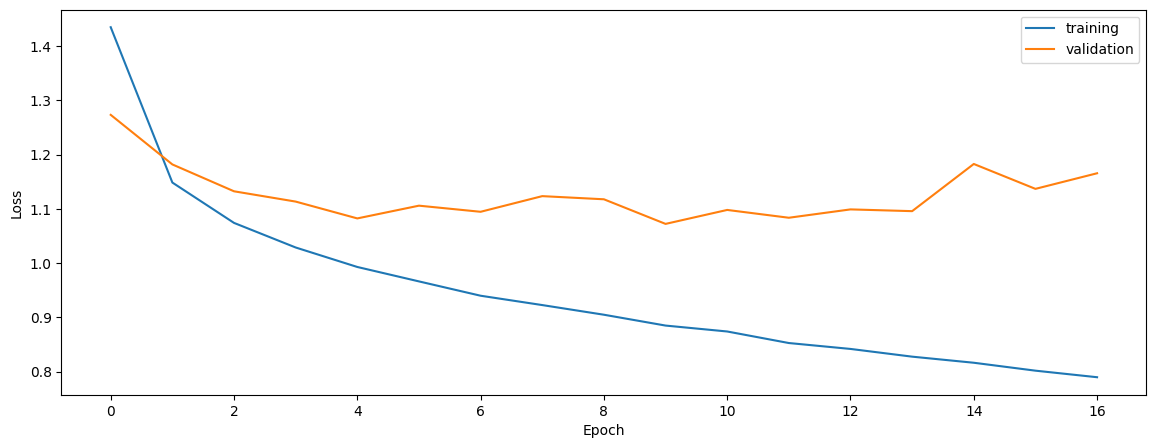

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6654216927843353
0.5705636850783182
0.6349231241918759


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized
0.6077722638211857
0.5853547889515376
0.5576657759042954


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native


0.606290723915229
0.5936746960238228
0.5636733442356351


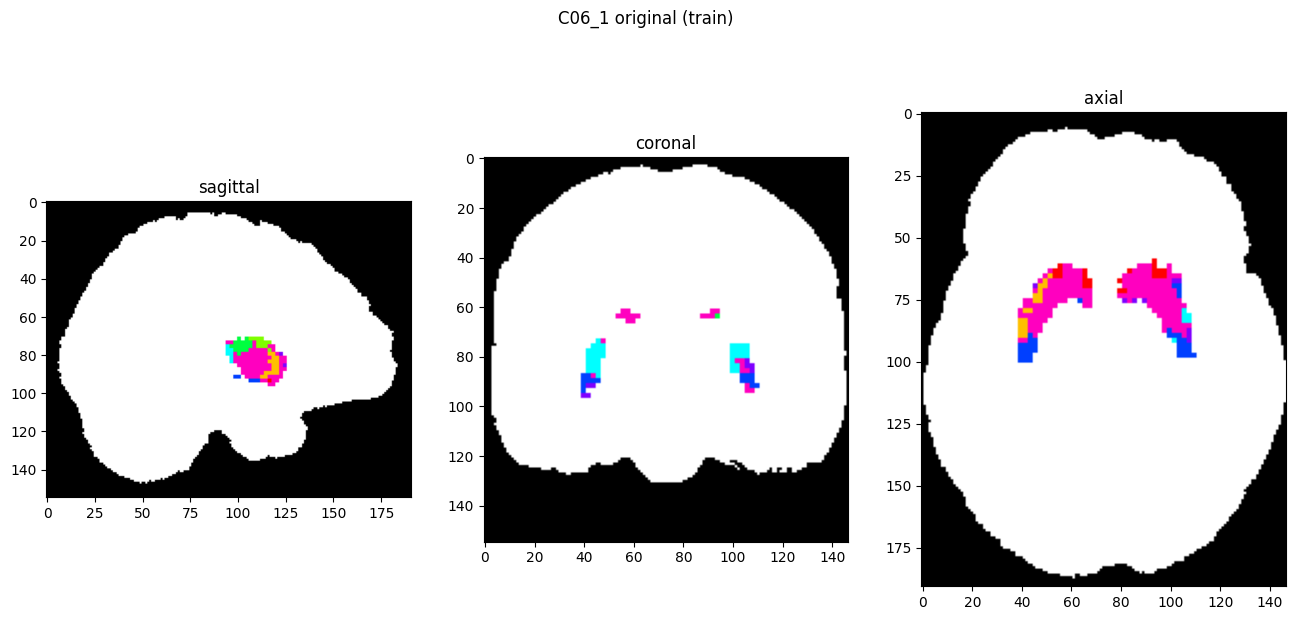

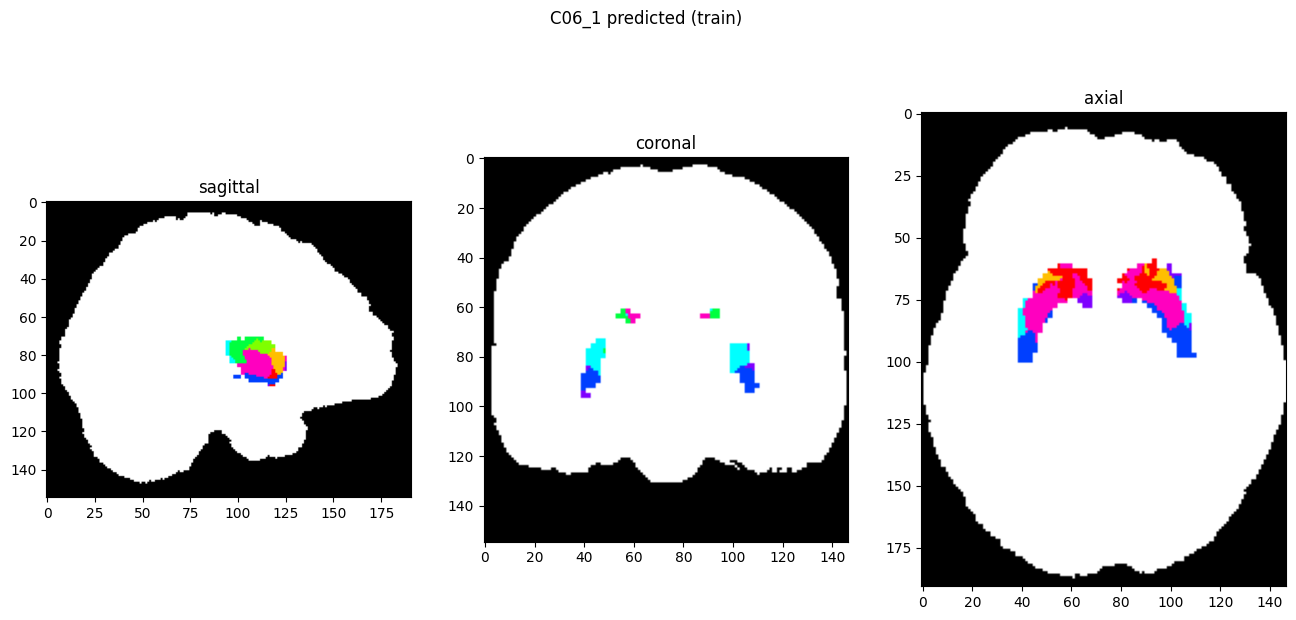

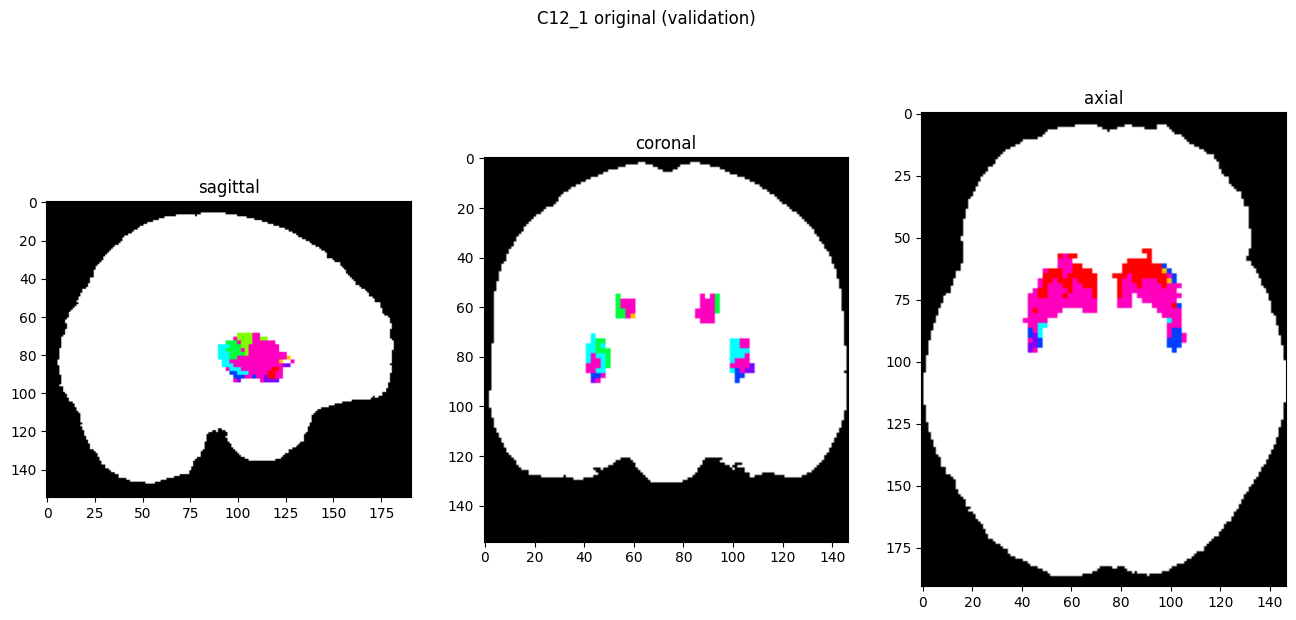

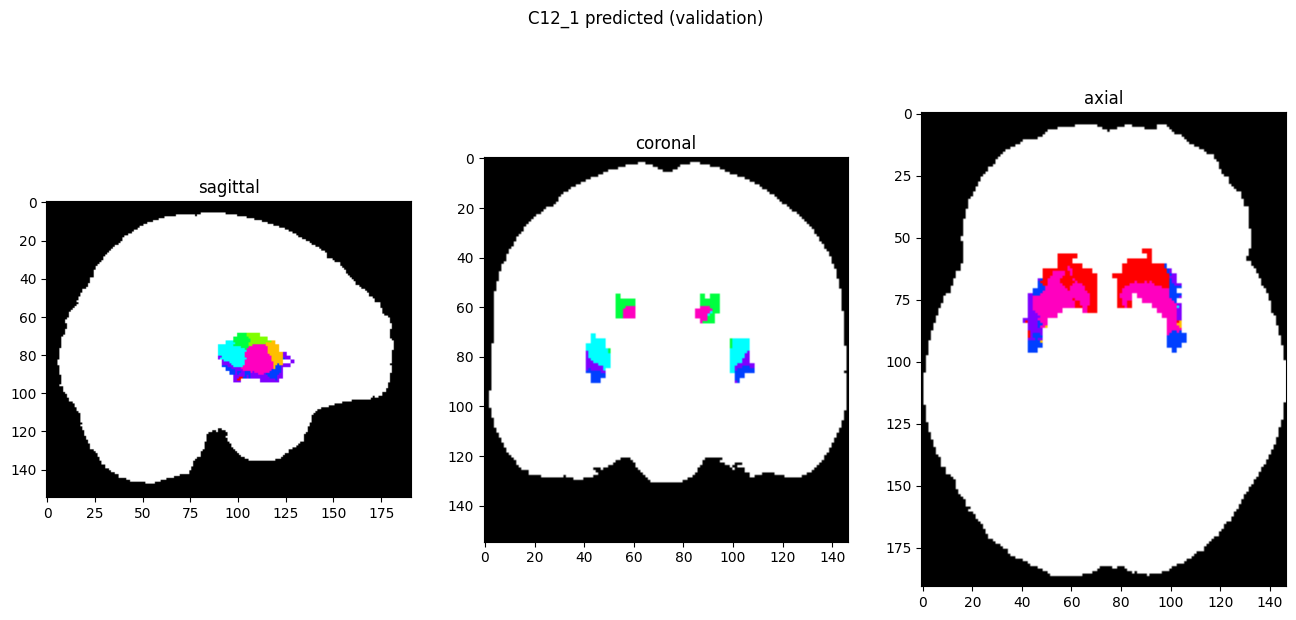

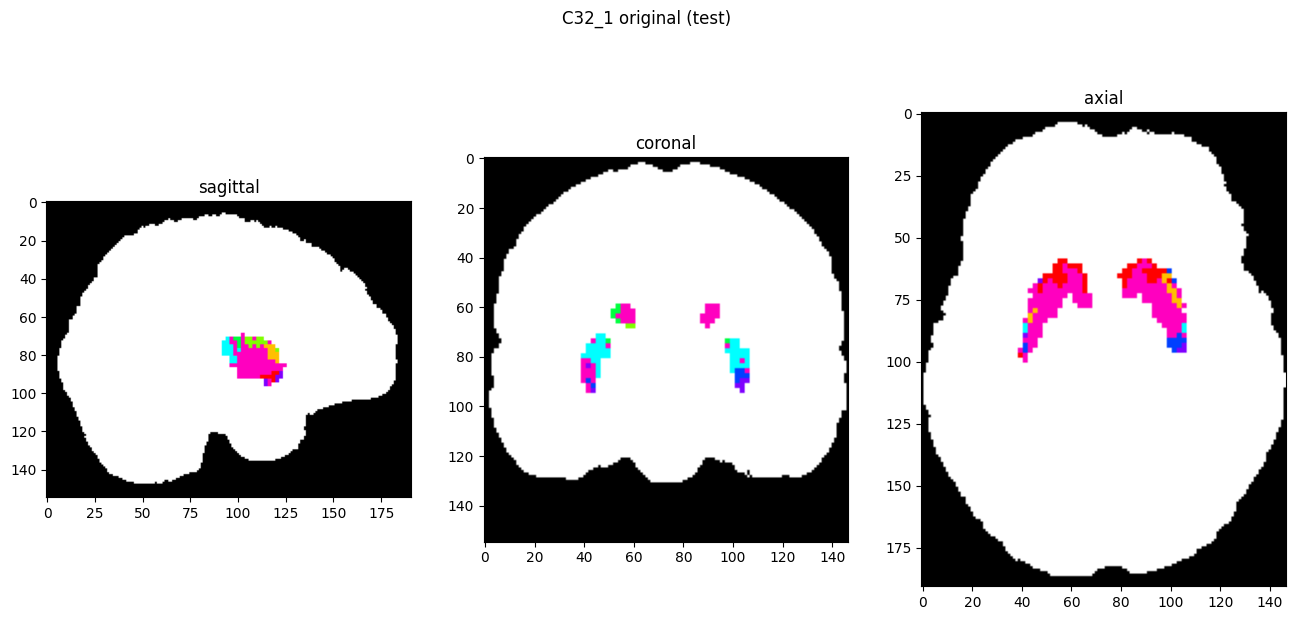

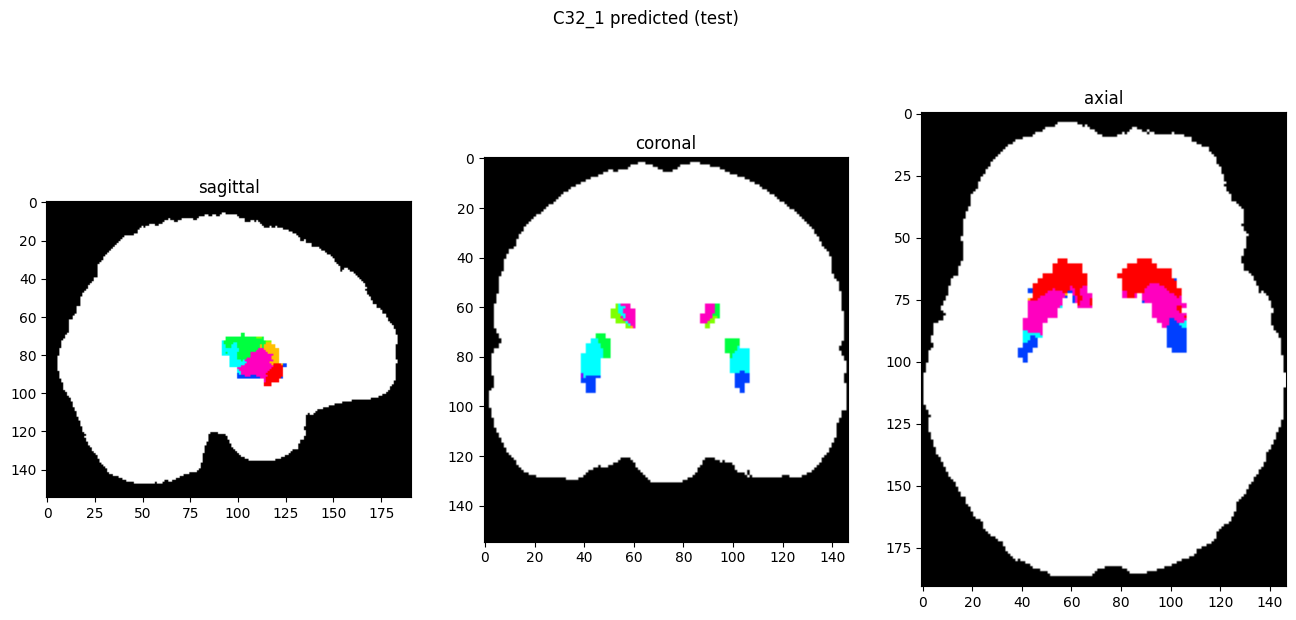

In [10]:
showResults(model, gen, threshold=0)